# PCA Analysis on Indian Market Indices: A Quantitative Finance Deep Dive
## Understanding Market Regimes Through Principal Component Analysis

---

## 🎯 Purpose of This Analysis

This notebook performs **Principal Component Analysis (PCA)** on **Indian market indices** instead of individual stocks. This is a **fundamentally different approach** that reveals:

1. **Capital Flow Patterns**: How money rotates between different market segments
2. **Regime Detection**: Identifying when market behavior fundamentally changes
3. **Sector Leadership**: Which sectors drive market movements
4. **Macro Factor Decomposition**: Understanding the underlying forces moving the market

---

## 📊 Why Indices Instead of Stocks?

### The Key Difference:

**Stock-Level PCA**:
- Reveals: Stock-specific factors, idiosyncratic risk, company-level correlations
- Use Case: Stock picking, portfolio construction, alpha generation

**Index-Level PCA**:
- Reveals: **Macro factors**, **capital flow patterns**, **regime shifts**
- Use Case: **Market timing**, **sector rotation**, **regime detection**, **risk management**

### Why This Matters:

When you analyze indices, you're analyzing **already-diversified baskets**. This means:
- **Noise is reduced**: Stock-specific events are averaged out
- **Signals are clearer**: Only macro-level patterns emerge
- **Regimes are visible**: You can see when the market shifts from "growth-driven" to "defensive-driven"

---

## 🧮 Mathematical Intuition

### What PCA Does (The Math):

Given a correlation matrix **C** of indices, PCA finds:

**C = P Λ P^T**

Where:
- **P** = Matrix of eigenvectors (principal components)
- **Λ** = Diagonal matrix of eigenvalues (variance explained)

Each eigenvector represents a **direction** in the space of indices where:
- **PC1**: Direction of maximum variance (usually "market risk")
- **PC2**: Second direction of maximum variance (usually "sector rotation")
- **PC3**: Third direction (often "style factors" or "global exposure")

### Why This Works for Indices:

Indices are **already factor portfolios**:
- NIFTY 50 = Market factor
- NIFTY IT = Tech factor
- NIFTY FMCG = Defensive factor

PCA on indices finds **how these factors relate to each other**, revealing:
- Which factors move together
- Which factors are orthogonal (independent)
- How much variance each factor explains

---

## 📈 Indices Being Analyzed

### Broad Market Indices:
- **NIFTY 50** (^NSEI): Large-cap market representation
- **NIFTY 100** (^NIFTY100): Extended large-cap
- **NIFTY 200** (^CNX200): Large + Mid-cap
- **NIFTY 500** (^CRSLDX): Broad market
- **NIFTY BANK** (^NSEBANK): Banking sector

### Sectoral Indices:
- **NIFTY IT** (^CNXIT): Technology sector
- **NIFTY PHARMA** (^CNXPHARMA): Pharmaceutical sector
- **NIFTY AUTO** (^CNXAUTO): Automotive sector
- **NIFTY METAL** (^CNXMETAL): Metals & mining
- **NIFTY FMCG** (^CNXFMCG): Fast-moving consumer goods
- **NIFTY ENERGY** (^CNXENERGY): Energy sector
- **NIFTY FINANCIAL SERVICES** (^CNXFIN): Financial services
- **NIFTY REALTY** (^CNXREALTY): Real estate
- **NIFTY PSU BANK** (^CNXPSUBANK): Public sector banks
- **NIFTY MEDIA** (^CNXMEDIA): Media sector

### Style/Theme Indices:
- **NIFTY MIDCAP 100** (^NIFMDCP100): Mid-cap companies
- **NIFTY SMALLCAP 100** (^NIFSMCP100): Small-cap companies
- **NIFTY CONSUMPTION** (^CNXCNSMP): Consumption theme

---

## 🔬 What We'll Discover

1. **PC1 Interpretation**: Usually represents "India Equity Risk Appetite"
   - High PC1 loading = Risk-on, growth-oriented
   - Low PC1 loading = Risk-off, defensive

2. **PC2 Interpretation**: Usually represents "Defensive vs Cyclical Rotation"
   - Positive = Defensive (FMCG, Pharma)
   - Negative = Cyclical (Metals, Energy, Infra)

3. **PC3 Interpretation**: Usually represents "Global vs Domestic" or "Style Factors"
   - IT vs Domestic consumption
   - USD-INR sensitivity
   - Export-oriented vs Import-oriented

4. **Regime Detection**: When PC dominance shifts, the market regime has changed

---

## 📝 Technical Notes & Methodology

### Data Requirements:
- **Period**: 1 year of daily data (adjustable)
- **Returns**: Log returns (ln(P_t / P_{t-1}))
- **Normalization**: Standardized returns for PCA

### PCA Methodology:
- **Correlation Matrix**: Computed from returns
- **Eigenvalue Decomposition**: Using NumPy's `linalg.eigh`
- **Variance Explained**: λ_i / Σλ_i × 100%

### Interpretation Framework:
- **PC Loadings**: How much each index contributes to that PC
- **PC Scores**: Time series of PC values (how active each factor is)
- **Regime Shifts**: Detected when dominant PC changes

---

## 🎓 Expected Insights

1. **Market Structure**: How many independent factors drive Indian markets?
2. **Sector Relationships**: Which sectors move together vs independently?
3. **Regime Stability**: How often do market regimes change?
4. **Factor Importance**: Which factors explain most variance?

---

Let's begin the analysis!


In [7]:
# Install required packages
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Standard libraries for analysis
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('dark_background')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")
print("📦 Using: yfinance, numpy, pandas, matplotlib, seaborn, scikit-learn")


✅ All libraries imported successfully!
📦 Using: yfinance, numpy, pandas, matplotlib, seaborn, scikit-learn


## 📊 Part 1: Data Collection - Indian Market Indices

**Why these indices?**
- **Broad Market**: Capture overall market sentiment (NIFTY 50, 100, 200, 500)
- **Sectoral**: Reveal sector-specific patterns (IT, Pharma, Auto, etc.)
- **Style/Theme**: Show market cap and theme rotations (Midcap, Smallcap, Consumption)

**Key Insight**: By analyzing indices, we're analyzing **macro factors**, not stock-specific noise.

**Note on Data Availability:**
- Some indices may not be available on Yahoo Finance (e.g., ^NIFTY100, ^CNXFIN, ^NIFMDCP100, ^NIFSMCP100, ^CNXCNSMP)
- These will be automatically excluded from analysis
- The code handles missing indices gracefully

**Why Unequal Trading Days?**

Different indices may show different numbers of trading days due to:
1. **Different listing dates**: Some indices were created later than others
2. **Data gaps**: Some indices may have missing data on certain holidays or dates
3. **Data provider issues**: Yahoo Finance may not have complete historical data for all indices

**Solution**: We align all indices on **common dates only** (intersection). This ensures:
- All indices have data for the same dates
- PCA computation is valid (requires same time periods)
- No missing values in the final dataset


In [9]:
# Define all Indian market indices
# Note: Some symbols may not be available on Yahoo Finance - they will be automatically removed
INDICES = [
    # BROADER INDICES
    '^NSEI',        # Nifty 50
    '^NSEBANK',     # Nifty Bank
    '^CNX200',      # Nifty 200
    '^CRSLDX',      # Nifty 500
    
    # SECTORAL INDICES
    '^CNXIT',       # Nifty IT
    '^CNXPHARMA',   # Nifty Pharma
    '^CNXAUTO',     # Nifty Auto
    '^CNXMETAL',    # Nifty Metal
    '^CNXFMCG',     # Nifty FMCG
    '^CNXENERGY',   # Nifty Energy
    '^CNXREALTY',   # Nifty Realty
    '^CNXPSUBANK',  # Nifty PSU Bank
    '^CNXMEDIA',    # Nifty Media
    
    # Note: The following indices are not available on Yahoo Finance:
    # '^NIFTY100',    # Nifty 100 - Not available
    # '^CNXFIN',      # Nifty Financial Services - Not available
    # '^NIFMDCP100',  # Nifty Midcap 100 - Not available
    # '^NIFSMCP100',  # Nifty Smallcap 100 - Not available
    # '^CNXCNSMP',    # Nifty Consumption - Not available
]

# Create index labels for better visualization
INDEX_LABELS = {
    '^NSEI': 'NIFTY 50',
    '^NSEBANK': 'NIFTY BANK',
    '^CNX200': 'NIFTY 200',
    '^CRSLDX': 'NIFTY 500',
    '^CNXIT': 'NIFTY IT',
    '^CNXPHARMA': 'NIFTY PHARMA',
    '^CNXAUTO': 'NIFTY AUTO',
    '^CNXMETAL': 'NIFTY METAL',
    '^CNXFMCG': 'NIFTY FMCG',
    '^CNXENERGY': 'NIFTY ENERGY',
    '^CNXREALTY': 'NIFTY REALTY',
    '^CNXPSUBANK': 'NIFTY PSU BANK',
    '^CNXMEDIA': 'NIFTY MEDIA',
    # Note: The following are not available on Yahoo Finance
    # '^NIFTY100': 'NIFTY 100',
    # '^CNXFIN': 'NIFTY FIN',
    # '^NIFMDCP100': 'NIFTY MIDCAP',
    # '^NIFSMCP100': 'NIFTY SMALLCAP',
    # '^CNXCNSMP': 'NIFTY CONSUMPTION',
}

print(f"📈 Total indices: {len(INDICES)}")
print(f"📋 Categories: Broad Market, Sectoral, Style/Theme")
print(f"\n🔍 Index list:")
for idx in INDICES:
    print(f"   - {INDEX_LABELS.get(idx, idx)}")


📈 Total indices: 13
📋 Categories: Broad Market, Sectoral, Style/Theme

🔍 Index list:
   - NIFTY 50
   - NIFTY BANK
   - NIFTY 200
   - NIFTY 500
   - NIFTY IT
   - NIFTY PHARMA
   - NIFTY AUTO
   - NIFTY METAL
   - NIFTY FMCG
   - NIFTY ENERGY
   - NIFTY REALTY
   - NIFTY PSU BANK
   - NIFTY MEDIA


In [10]:
# Fetch historical data using yfinance (parallelized)
from concurrent.futures import ThreadPoolExecutor, as_completed

PERIOD = "2y"  # 2 years of data for better statistical significance
INTERVAL = "1d"  # Daily data

returns_dict = {}
failed_symbols = []
successful_symbols = []

def fetch_index_return(symbol, idx, total):
    try:
        ticker = yf.Ticker(symbol)
        df = ticker.history(period=PERIOD, interval=INTERVAL)
        if df.empty:
            return (symbol, None, None, f"❌ [{idx:2d}/{total}] {symbol}: No data available")
        # Calculate log returns
        returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()
        if len(returns) < 100:  # Need sufficient data
            return (symbol, None, None, f"❌ [{idx:2d}/{total}] {symbol}: Insufficient data ({len(returns)} days)")
        return (symbol, returns, len(returns), f"✅ [{idx:2d}/{total}] {symbol}: {len(returns)} trading days")
    except Exception as e:
        return (symbol, None, None, f"❌ [{idx:2d}/{total}] {symbol}: Error - {str(e)[:50]}")

print("🔄 Fetching data for all indices using yfinance (parallelized)...")
print("=" * 60)

max_workers = min(20, len(INDICES))
futures = []
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    for i, symbol in enumerate(INDICES, 1):
        futures.append(executor.submit(fetch_index_return, symbol, i, len(INDICES)))
    for future in as_completed(futures):
        symbol, returns, num_days, msg = future.result()
        print(msg)
        if returns is None:
            failed_symbols.append(symbol)
        else:
            returns_dict[symbol] = returns
            successful_symbols.append((symbol, num_days))

print("=" * 60)
print(f"\n📊 Successfully fetched: {len(returns_dict)} indices")
if failed_symbols:
    print(f"⚠️  Failed: {len(failed_symbols)} indices - {', '.join(failed_symbols)}")
    print(f"💡 These indices will be automatically excluded from analysis")

# Show data availability by index
print(f"\n📅 Data Availability by Index:")
print("-" * 60)
for symbol, num_days in sorted(successful_symbols, key=lambda x: x[1], reverse=True):
    print(f"   {INDEX_LABELS.get(symbol, symbol):<25} {num_days:>4} trading days")

print(f"\n💡 Why Unequal Trading Days?")
print("   • Different indices may have different listing dates")
print("   • Some indices may have missing data on certain holidays")
print("   • Data alignment will use common dates only (intersection of all dates)")
print("   • This ensures all indices have data for the same dates in the final dataset")


🔄 Fetching data for all indices using yfinance (parallelized)...
✅ [ 1/13] ^NSEI: 495 trading days
✅ [ 3/13] ^CNX200: 494 trading days
✅ [ 5/13] ^CNXIT: 491 trading days
✅ [13/13] ^CNXMEDIA: 491 trading days
✅ [ 6/13] ^CNXPHARMA: 494 trading days
✅ [10/13] ^CNXENERGY: 491 trading days
✅ [ 7/13] ^CNXAUTO: 491 trading days
✅ [ 8/13] ^CNXMETAL: 491 trading days
✅ [ 2/13] ^NSEBANK: 491 trading days
✅ [ 9/13] ^CNXFMCG: 491 trading days
✅ [11/13] ^CNXREALTY: 491 trading days
✅ [ 4/13] ^CRSLDX: 491 trading days
✅ [12/13] ^CNXPSUBANK: 491 trading days

📊 Successfully fetched: 13 indices

📅 Data Availability by Index:
------------------------------------------------------------
   NIFTY 50                   495 trading days
   NIFTY 200                  494 trading days
   NIFTY PHARMA               494 trading days
   NIFTY IT                   491 trading days
   NIFTY MEDIA                491 trading days
   NIFTY ENERGY               491 trading days
   NIFTY AUTO                 491 tradin

In [11]:
# Align all returns on common dates
print("\n" + "=" * 60)
print("📐 DATA ALIGNMENT PROCESS")
print("=" * 60)

# Create DataFrame from successful fetches
returns_df_raw = pd.DataFrame(returns_dict)

print(f"\n📊 Before Alignment:")
print(f"   • Raw data shape: {returns_df_raw.shape[0]} days × {returns_df_raw.shape[1]} indices")
print(f"   • Date range: {returns_df_raw.index[0].date()} to {returns_df_raw.index[-1].date()}")

# Show date coverage per index before alignment
print(f"\n📅 Date Coverage Before Alignment:")
for col in returns_df_raw.columns:
    non_null_count = returns_df_raw[col].notna().sum()
    print(f"   • {INDEX_LABELS.get(col, col):<25} {non_null_count:>4} days with data")

# Align on common dates (intersection - only dates where ALL indices have data)
returns_df = returns_df_raw.dropna()  # Remove rows with any NaN

# Rename columns for better visualization
returns_df.columns = [INDEX_LABELS.get(col, col) for col in returns_df.columns]

print(f"\n📊 After Alignment (Common Dates Only):")
print(f"   • Final dataset shape: {returns_df.shape[0]} days × {returns_df.shape[1]} indices")
print(f"   • Date range: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
print(f"   • Total data points: {returns_df.shape[0] * returns_df.shape[1]:,}")

# Show how many days were lost due to alignment
days_lost = len(returns_df_raw) - len(returns_df)
if days_lost > 0:
    print(f"\n⚠️  Note: {days_lost} days removed due to missing data in some indices")
    print(f"   This ensures all indices have data for the same dates (required for PCA)")

# Show sample of the data
print("\n📋 Sample of returns data (first 5 days, first 5 indices):")
print(returns_df.iloc[:5, :5].round(4))
print("\n💡 Each value is the log return: ln(Price_today / Price_yesterday)")

# Basic statistics
print("\n📊 Basic Statistics (Aligned Data):")
print(f"   Mean return (daily): {returns_df.mean().mean():.6f}")
print(f"   Std dev (daily): {returns_df.std().mean():.6f}")
print(f"   Min return: {returns_df.min().min():.6f}")
print(f"   Max return: {returns_df.max().max():.6f}")

# Verify all indices have same number of observations
print(f"\n✅ Data Quality Check:")
all_same_length = all(returns_df[col].notna().sum() == len(returns_df) for col in returns_df.columns)
if all_same_length:
    print(f"   ✓ All indices have exactly {len(returns_df)} observations (perfect alignment)")
else:
    print(f"   ⚠️  Warning: Some indices have different observation counts")



📐 DATA ALIGNMENT PROCESS

📊 Before Alignment:
   • Raw data shape: 495 days × 13 indices
   • Date range: 2023-12-19 to 2025-12-18

📅 Date Coverage Before Alignment:
   • NIFTY 50                   495 days with data
   • NIFTY 200                  494 days with data
   • NIFTY IT                   491 days with data
   • NIFTY MEDIA                491 days with data
   • NIFTY PHARMA               494 days with data
   • NIFTY ENERGY               491 days with data
   • NIFTY AUTO                 491 days with data
   • NIFTY METAL                491 days with data
   • NIFTY BANK                 491 days with data
   • NIFTY FMCG                 491 days with data
   • NIFTY REALTY               491 days with data
   • NIFTY 500                  491 days with data
   • NIFTY PSU BANK             491 days with data

📊 After Alignment (Common Dates Only):
   • Final dataset shape: 491 days × 13 indices
   • Date range: 2023-12-19 to 2025-12-18
   • Total data points: 6,383

⚠️  Note:

## 🔢 Part 2: Computing Correlation Matrix

**What is correlation for indices?**
- Measures how two indices move together
- Range: -1 (opposite) to +1 (same direction)
- 0 means no linear relationship

**Why compute correlation on indices?**
- Understand **sector relationships**
- Identify **capital flow patterns**
- Find **regime-dependent correlations**

**Key Insight**: Index correlations reveal **macro structure**, not stock-specific noise.


In [13]:
# Compute correlation matrix
corr_matrix = returns_df.corr()

print("🔢 Correlation Matrix Computation")
print("=" * 60)
print(f"📐 Matrix shape: {corr_matrix.shape[0]} × {corr_matrix.shape[1]} (symmetric matrix)")
print(f"📊 Total correlations: {corr_matrix.shape[0] * corr_matrix.shape[1]}")

# Extract upper triangle (excluding diagonal) for statistics
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]

print(f"\n📈 Correlation Statistics:")
print(f"   Mean correlation: {upper_triangle.mean():.4f}")
print(f"   Min correlation:  {upper_triangle.min():.4f}")
print(f"   Max correlation:  {upper_triangle.max():.4f}")
print(f"   Std deviation:    {upper_triangle.std():.4f}")

# # Show some example correlations
# print(f"\n💡 Example Correlations:")
# print(f"   NIFTY 50 vs NIFTY 100: {corr_matrix.loc['NIFTY 50', 'NIFTY 100']:.4f}")
# print(f"   NIFTY IT vs NIFTY PHARMA: {corr_matrix.loc['NIFTY IT', 'NIFTY PHARMA']:.4f}")
# print(f"   NIFTY FMCG vs NIFTY METAL: {corr_matrix.loc['NIFTY FMCG', 'NIFTY METAL']:.4f}")

print("\n📋 Correlation Matrix:")
display(corr_matrix.round(3))


🔢 Correlation Matrix Computation
📐 Matrix shape: 13 × 13 (symmetric matrix)
📊 Total correlations: 169

📈 Correlation Statistics:
   Mean correlation: 0.5775
   Min correlation:  0.2148
   Max correlation:  0.9955
   Std deviation:    0.1917

📋 Correlation Matrix:


,NIFTY 50,NIFTY 200,NIFTY IT,NIFTY MEDIA,NIFTY PHARMA,NIFTY ENERGY,NIFTY AUTO,NIFTY METAL,NIFTY BANK,NIFTY FMCG,NIFTY REALTY,NIFTY 500,NIFTY PSU BANK
NIFTY 50,1.000,0.971,0.581,0.495,0.542,0.791,0.761,0.749,0.859,0.528,0.670,0.952,0.665
NIFTY 200,0.971,1.000,0.540,0.592,0.597,0.859,0.785,0.814,0.843,0.504,0.753,0.996,0.747
NIFTY IT,0.581,0.540,1.000,0.224,0.328,0.320,0.388,0.361,0.304,0.311,0.320,0.524,0.219
NIFTY MEDIA,0.495,0.592,0.224,1.000,0.425,0.582,0.465,0.562,0.425,0.296,0.536,0.632,0.532
NIFTY PHARMA,0.542,0.597,0.328,0.425,1.000,0.517,0.521,0.535,0.374,0.310,0.458,0.614,0.401
NIFTY ENERGY,0.791,0.859,0.320,0.582,0.517,1.000,0.617,0.782,0.659,0.322,0.652,0.869,0.771
NIFTY AUTO,0.761,0.785,0.388,0.465,0.521,0.617,1.000,0.649,0.587,0.438,0.609,0.784,0.512
NIFTY METAL,0.749,0.814,0.361,0.562,0.535,0.782,0.649,1.000,0.621,0.290,0.646,0.826,0.653
NIFTY BANK,0.859,0.843,0.304,0.425,0.374,0.659,0.587,0.621,1.000,0.346,0.597,0.827,0.725
NIFTY FMCG,0.528,0.504,0.311,0.296,0.310,0.322,0.438,0.290,0.346,1.000,0.346,0.491,0.215


## 🎨 Part 3: Visualizing Correlations

**Why visualize index correlations?**
- See **sector clustering** at a glance
- Identify **defensive vs cyclical** patterns
- Understand **market structure** visually

**What to look for:**
- **High correlations** (red) = Indices move together (e.g., NIFTY 50, 100, 200)
- **Low correlations** (blue/white) = Independent movement (e.g., IT vs FMCG)
- **Negative correlations** (blue) = Opposite movement (rare but important)


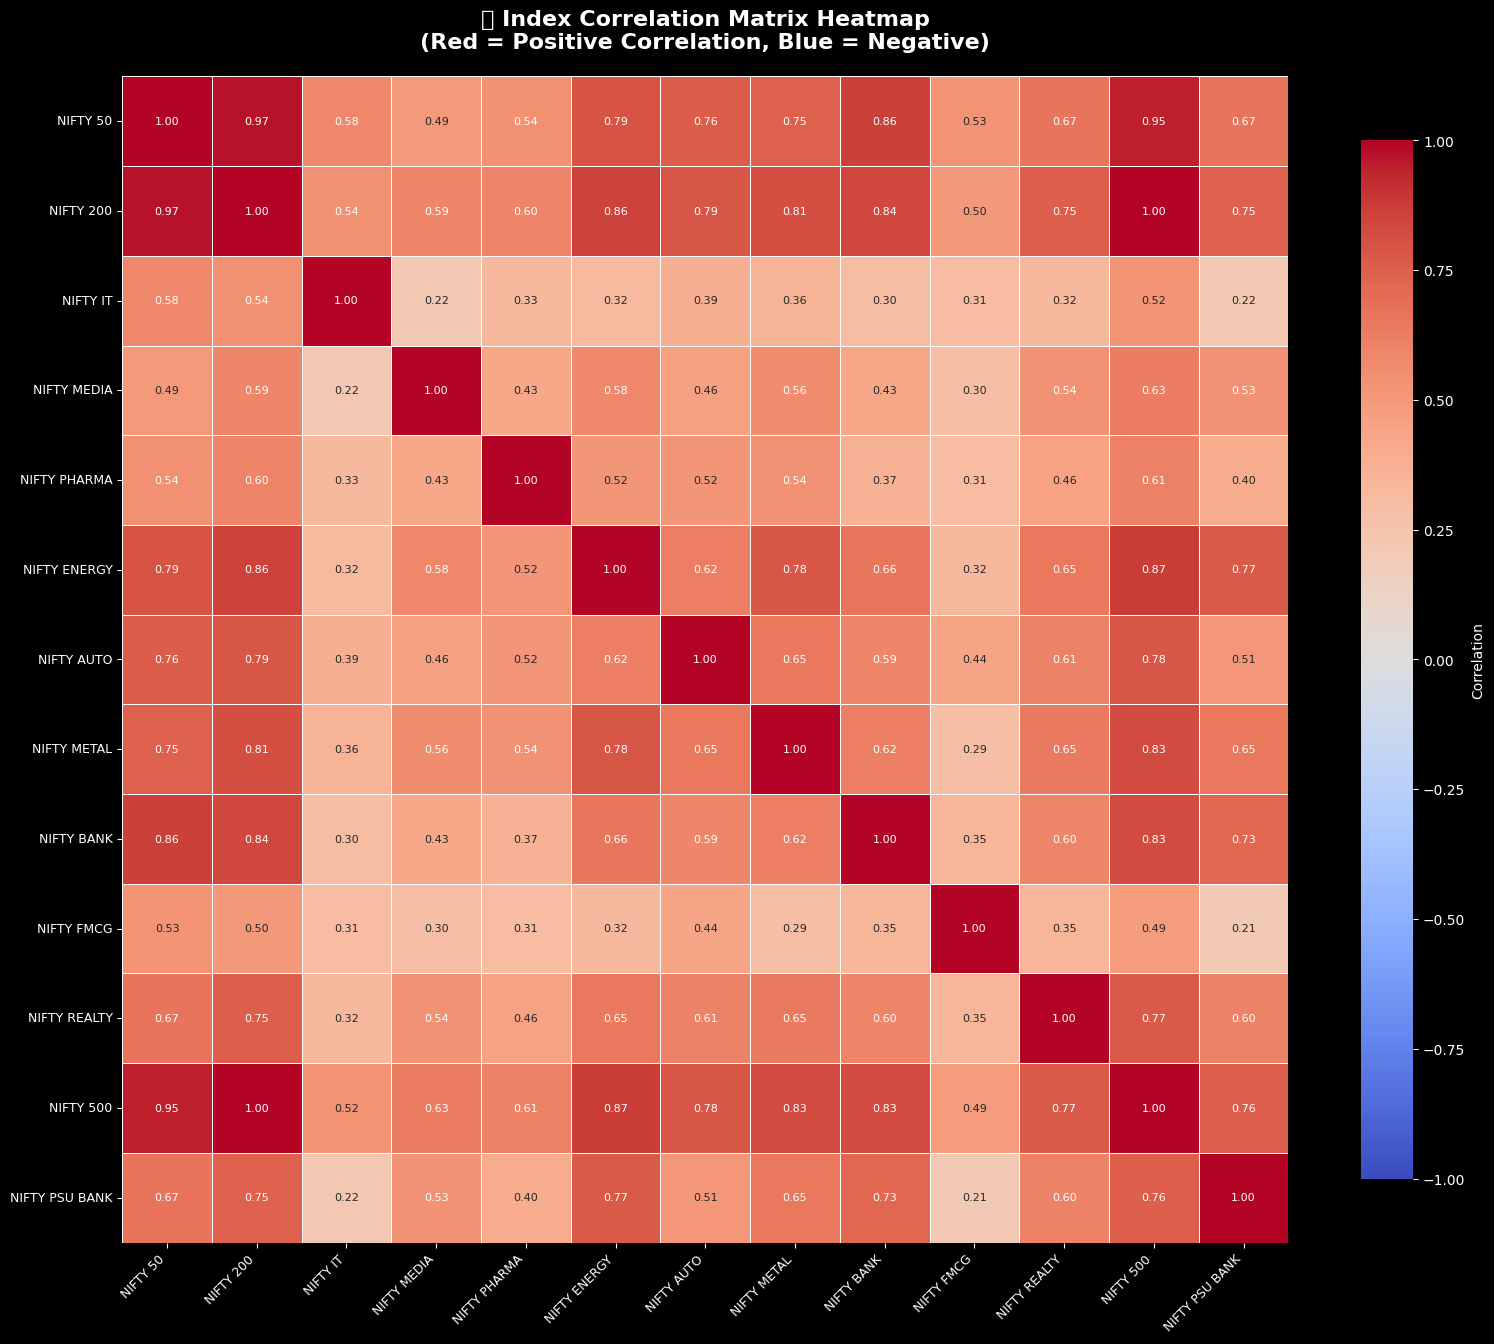

💡 Interpretation:
   🔴 Red/Orange = Indices move together (high correlation)
   🔵 Blue = Indices move opposite (negative correlation)
   ⚪ White = No correlation (independent movement)

   Notice: Broad market indices (NIFTY 50, 100, 200) are highly correlated
   Notice: Defensive (FMCG, Pharma) vs Cyclical (Metal, Energy) may show lower correlation


In [14]:
# Visualize correlation matrix as heatmap
fig, ax = plt.subplots(figsize=(16, 14))

# Create heatmap
sns.heatmap(
    corr_matrix,
    annot=True,  # Show correlation values
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    annot_kws={"size": 8}
)

ax.set_title('📊 Index Correlation Matrix Heatmap\n(Red = Positive Correlation, Blue = Negative)', 
              fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

print("💡 Interpretation:")
print("   🔴 Red/Orange = Indices move together (high correlation)")
print("   🔵 Blue = Indices move opposite (negative correlation)")
print("   ⚪ White = No correlation (independent movement)")
print("\n   Notice: Broad market indices (NIFTY 50, 100, 200) are highly correlated")
print("   Notice: Defensive (FMCG, Pharma) vs Cyclical (Metal, Energy) may show lower correlation")


## 🧮 Part 4: Principal Component Analysis

**What is PCA doing here?**
- Finding the **main directions** where indices move together
- Decomposing correlation structure into **orthogonal factors**
- Identifying **how many independent factors** drive the market

**Key Mathematical Concept:**
- **Eigenvalue Decomposition**: C = P Λ P^T
- **Eigenvalues (λ)**: Variance explained by each PC
- **Eigenvectors (P)**: Directions of maximum variance

**For Indices, This Reveals:**
- **PC1**: Usually "Market Risk" or "India Equity Risk Appetite"
- **PC2**: Usually "Defensive vs Cyclical Rotation"
- **PC3**: Usually "Global vs Domestic" or "Style Factors"


In [15]:
# ============================================================================
# STEP: Find Eigenvectors and Eigenvalues - THE CORE OF PCA!
# ============================================================================

print("=" * 70)
print("🔬 COMPUTING EIGENVECTORS AND EIGENVALUES")
print("=" * 70)
print("")
print("💡 What's happening:")
print("   - We're analyzing the correlation matrix of indices")
print("   - Finding the main 'directions' where indices move (eigenvectors)")
print("   - Finding how 'important' each direction is (eigenvalues)")
print("   - This reveals the underlying factor structure of Indian markets")
print("")

# Use NumPy's eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(corr_matrix)

# Sort in descending order (largest eigenvalue first)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("✅ Decomposition complete!")
print(f"📊 Number of eigenvalues: {len(eigenvalues)}")
print(f"📊 Number of eigenvectors: {eigenvectors.shape[1]}")
print("")

# Calculate variance explained
pve = eigenvalues / eigenvalues.sum() * 100
cumulative_pve = np.cumsum(pve)

print("=" * 70)
print("📈 VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT")
print("=" * 70)
print("")
print("💡 This is the KEY metric for index PCA!")
print("   - Shows what % of all index movement each PC captures")
print("   - PC1 usually captures the most (the 'market factor')")
print("   - Later PCs capture sector rotations and style factors")
print("")
print(f"{'PC':<6} {'Eigenvalue':<12} {'Variance %':<12} {'Cumulative %':<15} {'Interpretation':<30}")
print("-" * 85)

# Show top 10 PCs
for i in range(min(10, len(pve))):
    if i == 0:
        interp = "Market Risk / Risk Appetite"
    elif i == 1:
        interp = "Defensive vs Cyclical"
    elif i == 2:
        interp = "Global vs Domestic"
    else:
        interp = "Sector/Style Factor"
    
    print(f"PC{i+1:<5} {eigenvalues[i]:<12.4f} {pve[i]:<12.2f}% {cumulative_pve[i]:<15.2f}% {interp}")

print("")
print("=" * 70)
print("💡 KEY INSIGHTS:")
print("=" * 70)

n_80 = np.argmax(cumulative_pve >= 80) + 1 if cumulative_pve[-1] >= 80 else len(eigenvalues)
n_90 = np.argmax(cumulative_pve >= 90) + 1 if cumulative_pve[-1] >= 90 else len(eigenvalues)
n_95 = np.argmax(cumulative_pve >= 95) + 1 if cumulative_pve[-1] >= 95 else len(eigenvalues)

print(f"   • First {n_80} PCs explain 80% of all variance")
print(f"   • First {n_90} PCs explain 90% of all variance")
print(f"   • First {n_95} PCs explain 95% of all variance")
print("")
print(f"   🎯 This means we can simplify {len(eigenvalues)} indices to just {n_80}-{n_90} factors!")
print(f"   🎯 Most of the market movement is captured by the first few PCs!")
print(f"   🎯 PC1 is the 'market factor' - when risk appetite changes, most indices move together")
print("=" * 70)


🔬 COMPUTING EIGENVECTORS AND EIGENVALUES

💡 What's happening:
   - We're analyzing the correlation matrix of indices
   - Finding the main 'directions' where indices move (eigenvectors)
   - Finding how 'important' each direction is (eigenvalues)
   - This reveals the underlying factor structure of Indian markets

✅ Decomposition complete!
📊 Number of eigenvalues: 13
📊 Number of eigenvectors: 13

📈 VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT

💡 This is the KEY metric for index PCA!
   - Shows what % of all index movement each PC captures
   - PC1 usually captures the most (the 'market factor')
   - Later PCs capture sector rotations and style factors

PC     Eigenvalue   Variance %   Cumulative %    Interpretation                
-------------------------------------------------------------------------------------
PC1     8.2231       63.25       % 63.25          % Market Risk / Risk Appetite
PC2     1.0843       8.34        % 71.60          % Defensive vs Cyclical
PC3     0.7609   

## 📊 Part 5: Visualizing Eigenvalues and Variance Explained

**Why visualize eigenvalues?**
- **Scree Plot**: Shows the "elbow" - how many PCs matter
- **Variance Explained**: Shows what % each PC captures
- **Cumulative Variance**: Shows how many PCs we need

**Key Questions:**
1. How many independent factors drive Indian markets?
2. Does PC1 dominate (market-driven) or are multiple factors important?
3. What's the "elbow" in the scree plot?


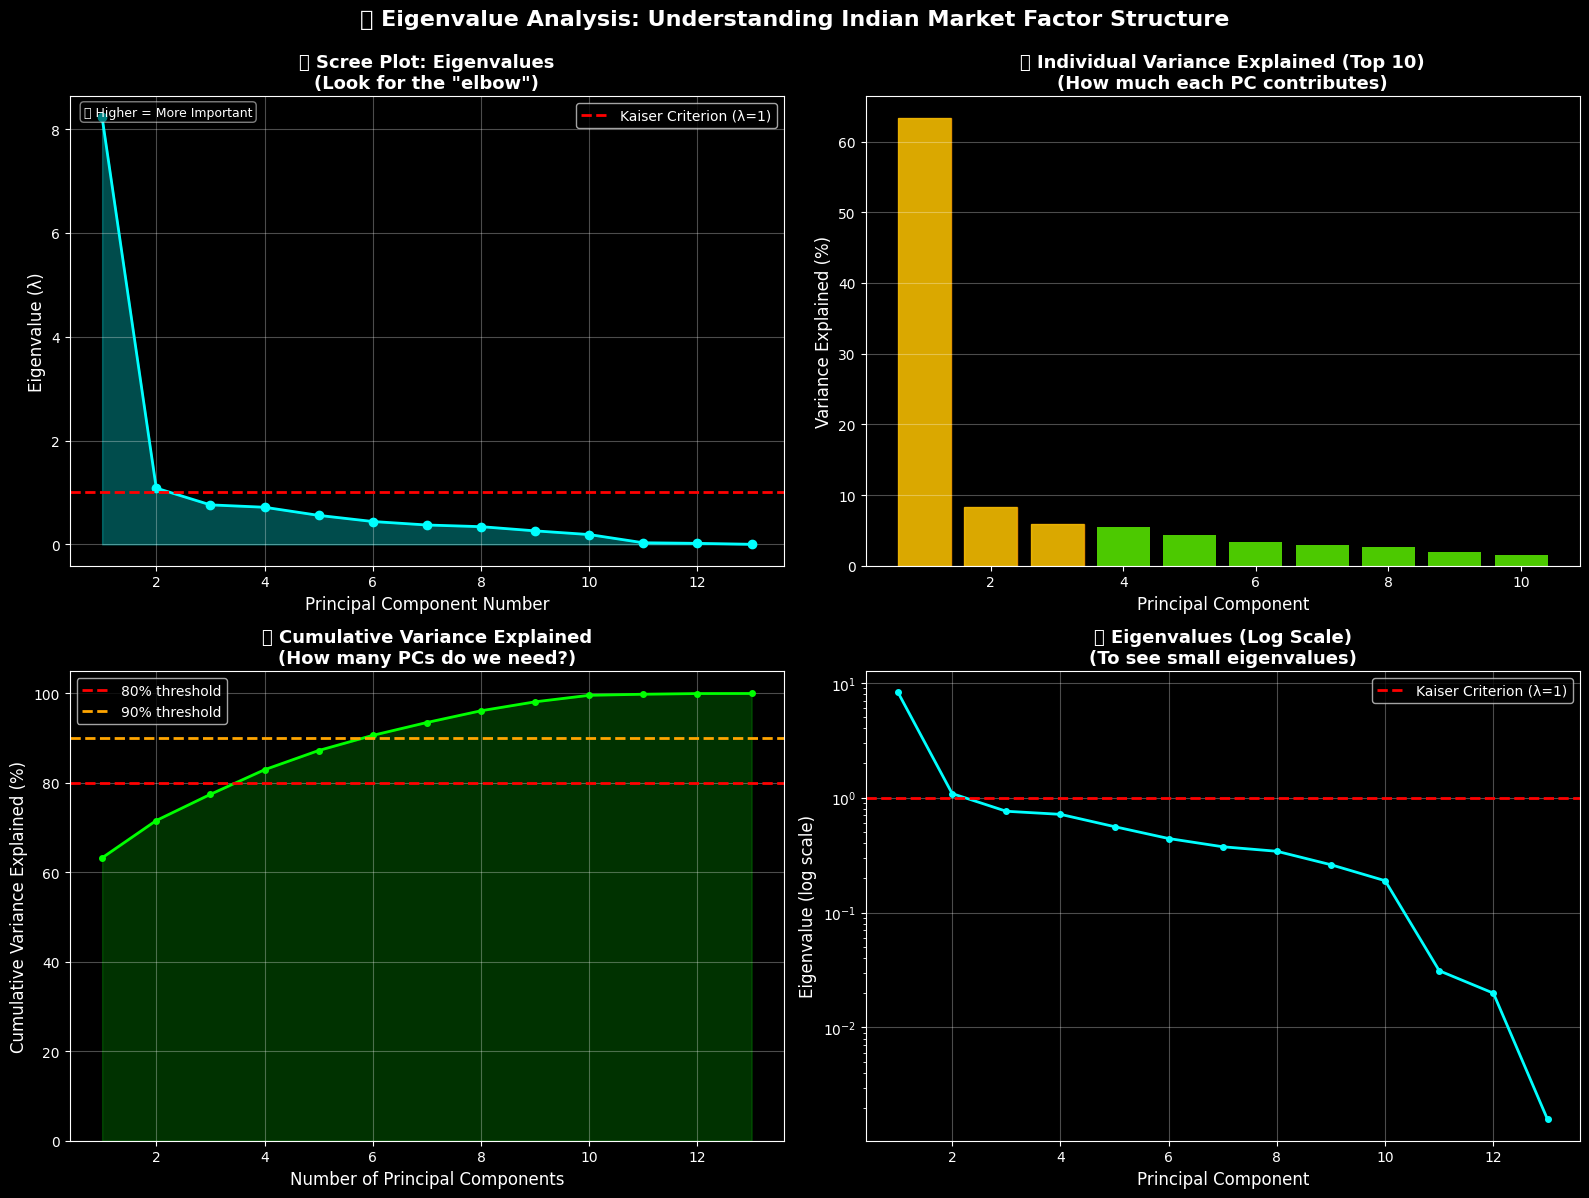


💡 KEY INSIGHTS FROM EIGENVALUE ANALYSIS
📊 Number of PCs needed for 80% variance: 4
📊 Number of PCs needed for 90% variance: 6
📊 Number of PCs needed for 95% variance: 8

🎯 Interpretation:
   • We can reduce 13 indices to 4 factors (80% variance)
   • This means most indices move together due to common factors!
   • The first few eigenvectors capture the 'market factor'
   • Remaining eigenvectors capture sector-specific or style factors


In [16]:
# Create comprehensive eigenvalue visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Eigenvalue Analysis: Understanding Indian Market Factor Structure', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Scree Plot (Eigenvalues)
axes[0, 0].plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', linewidth=2, markersize=6, color='cyan')
axes[0, 0].axhline(y=1, color='r', linestyle='--', linewidth=2, label='Kaiser Criterion (λ=1)')
axes[0, 0].fill_between(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.3, color='cyan')
axes[0, 0].set_xlabel('Principal Component Number', fontsize=12)
axes[0, 0].set_ylabel('Eigenvalue (λ)', fontsize=12)
axes[0, 0].set_title('🔍 Scree Plot: Eigenvalues\n(Look for the "elbow")', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.98, '💡 Higher = More Important', transform=axes[0, 0].transAxes, 
                fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

# Plot 2: Proportion of Variance Explained (Bar Chart)
top_n = min(10, len(pve))
bars = axes[0, 1].bar(range(1, top_n + 1), pve[:top_n], alpha=0.7, color='lime')
axes[0, 1].bar(range(1, top_n + 1), pve[:top_n], alpha=0.3, color='yellow')
axes[0, 1].set_xlabel('Principal Component', fontsize=12)
axes[0, 1].set_ylabel('Variance Explained (%)', fontsize=12)
axes[0, 1].set_title(f'📈 Individual Variance Explained (Top {top_n})\n(How much each PC contributes)', 
                     fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
# Highlight top 3
for i in range(min(3, top_n)):
    bars[i].set_color('orange')
    bars[i].set_alpha(0.8)

# Plot 3: Cumulative Variance Explained
line = axes[1, 0].plot(range(1, len(cumulative_pve) + 1), cumulative_pve, 'o-', linewidth=2, markersize=4, color='lime')
axes[1, 0].axhline(y=80, color='r', linestyle='--', linewidth=2, label='80% threshold')
axes[1, 0].axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% threshold')
axes[1, 0].fill_between(range(1, len(cumulative_pve) + 1), cumulative_pve, alpha=0.2, color='lime')
axes[1, 0].set_xlabel('Number of Principal Components', fontsize=12)
axes[1, 0].set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
axes[1, 0].set_title('📊 Cumulative Variance Explained\n(How many PCs do we need?)', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 105])

# Plot 4: Log Scale Eigenvalues
axes[1, 1].semilogy(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', linewidth=2, markersize=4, color='cyan')
axes[1, 1].axhline(y=1, color='r', linestyle='--', linewidth=2, label='Kaiser Criterion (λ=1)')
axes[1, 1].set_xlabel('Principal Component', fontsize=12)
axes[1, 1].set_ylabel('Eigenvalue (log scale)', fontsize=12)
axes[1, 1].set_title('🔬 Eigenvalues (Log Scale)\n(To see small eigenvalues)', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
n_components_80 = np.argmax(cumulative_pve >= 80) + 1 if cumulative_pve[-1] >= 80 else len(eigenvalues)
n_components_90 = np.argmax(cumulative_pve >= 90) + 1 if cumulative_pve[-1] >= 90 else len(eigenvalues)
n_components_95 = np.argmax(cumulative_pve >= 95) + 1 if cumulative_pve[-1] >= 95 else len(eigenvalues)

print("\n" + "="*60)
print("💡 KEY INSIGHTS FROM EIGENVALUE ANALYSIS")
print("="*60)
print(f"📊 Number of PCs needed for 80% variance: {n_components_80}")
print(f"📊 Number of PCs needed for 90% variance: {n_components_90}")
print(f"📊 Number of PCs needed for 95% variance: {n_components_95}")
print(f"\n🎯 Interpretation:")
print(f"   • We can reduce {len(eigenvalues)} indices to {n_components_80} factors (80% variance)")
print(f"   • This means most indices move together due to common factors!")
print(f"   • The first few eigenvectors capture the 'market factor'")
print(f"   • Remaining eigenvectors capture sector-specific or style factors")
print("="*60)


## 🎯 Part 6: Understanding Eigenvector Loadings

**What are eigenvector loadings?**
- Each loading shows **how much an index contributes** to that PC
- **Positive loading** = Index moves in that direction
- **Negative loading** = Index moves opposite to that direction
- **Large absolute value** = Index is strongly associated with that factor

**Why this matters for indices:**
- **PC1 Loadings**: Which indices are most "market-like" (high beta)
- **PC2 Loadings**: Which indices are defensive vs cyclical
- **PC3 Loadings**: Which indices are global vs domestic

**Key Insight**: Loadings reveal **sector characteristics** and **factor exposures**.


In [17]:
# Create DataFrame of eigenvectors (PC loadings)
pc_loadings = pd.DataFrame(
    eigenvectors,
    index=corr_matrix.index,
    columns=[f'PC{i+1}' for i in range(len(eigenvalues))]
)

print("📊 Top 5 Principal Components Loadings:")
print("=" * 80)
display(pc_loadings[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].round(4))


📊 Top 5 Principal Components Loadings:


,PC1,PC2,PC3,PC4,PC5
NIFTY 50,0.3293,0.1559,-0.2320,-0.0171,-0.0691
NIFTY 200,0.3446,0.0485,-0.1085,0.0018,-0.0263
NIFTY IT,0.1778,0.5854,-0.2173,0.5615,0.4063
NIFTY MEDIA,0.2296,-0.2182,0.5179,-0.0722,0.6602
NIFTY PHARMA,0.2228,0.1130,0.5852,0.3293,-0.5441
NIFTY ENERGY,0.3044,-0.2254,-0.0078,0.0404,0.0021
NIFTY AUTO,0.2788,0.1383,0.0796,-0.0491,-0.2508
NIFTY METAL,0.2946,-0.1559,0.0700,0.1690,-0.0326
NIFTY BANK,0.2858,-0.1225,-0.4340,-0.1839,-0.1384
NIFTY FMCG,0.1755,0.5423,0.1802,-0.7064,0.0383


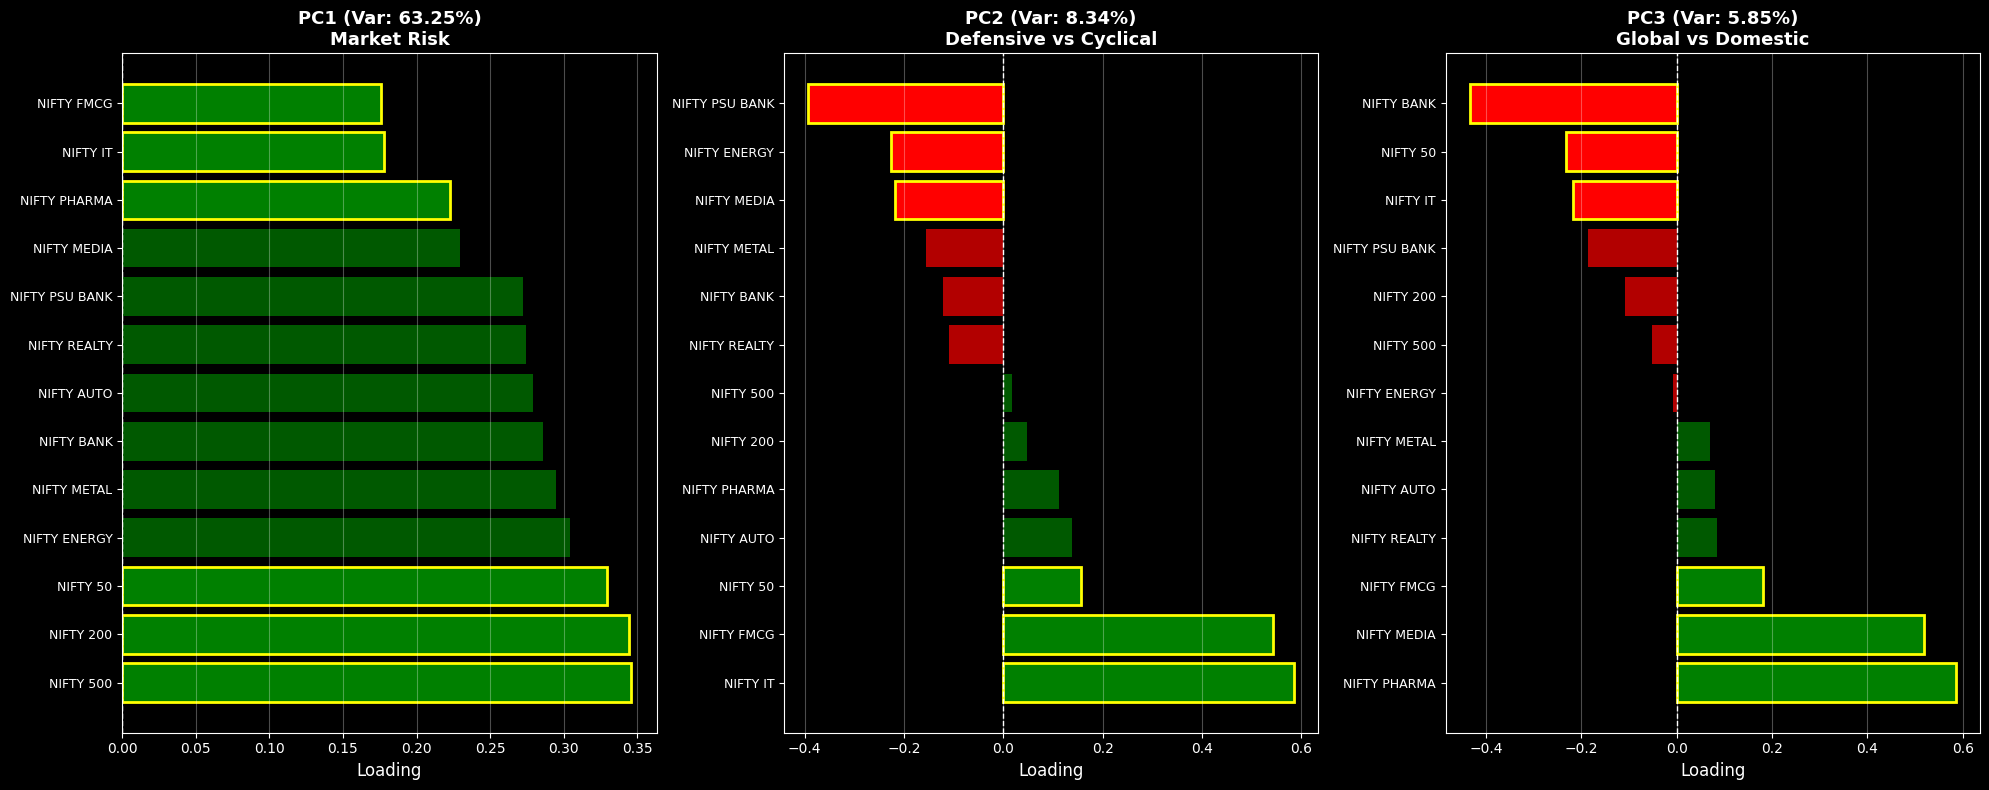


💡 Interpretation Guide:
   🟢 Green bars = Positive loading (moves with this factor)
   🔴 Red bars = Negative loading (moves opposite to this factor)
   ⭐ Yellow outline = Top/Bottom 3 loadings (most important for this factor)


In [18]:
# Visualize top 3 principal components with detailed interpretation
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, pc in enumerate(['PC1', 'PC2', 'PC3'], 1):
    ax = axes[idx - 1]
    loadings = pc_loadings[pc].sort_values(ascending=False)
    
    colors = ['green' if x > 0 else 'red' for x in loadings.values]
    bars = ax.barh(range(len(loadings)), loadings.values, color=colors, alpha=0.7)
    ax.set_yticks(range(len(loadings)))
    ax.set_yticklabels(loadings.index, fontsize=9)
    ax.set_xlabel('Loading', fontsize=12)
    ax.set_title(f'{pc} (Var: {pve[idx-1]:.2f}%)\n{["Market Risk", "Defensive vs Cyclical", "Global vs Domestic"][idx-1]}', 
                 fontsize=13, fontweight='bold')
    ax.axvline(x=0, color='white', linestyle='--', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Highlight top and bottom 3
    for i in range(min(3, len(loadings))):
        bars[i].set_alpha(1.0)
        bars[i].set_edgecolor('yellow')
        bars[i].set_linewidth(2)
    for i in range(max(0, len(loadings)-3), len(loadings)):
        bars[i].set_alpha(1.0)
        bars[i].set_edgecolor('yellow')
        bars[i].set_linewidth(2)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation Guide:")
print("   🟢 Green bars = Positive loading (moves with this factor)")
print("   🔴 Red bars = Negative loading (moves opposite to this factor)")
print("   ⭐ Yellow outline = Top/Bottom 3 loadings (most important for this factor)")


## 📈 Part 7: PC1 vs PC2 Scatter Plot - Market Regime Visualization

**Why PC1 vs PC2 scatter?**
- Shows **market structure** in 2D space
- Reveals **clustering** of similar indices
- Identifies **outliers** (indices that behave differently)

**What to look for:**
- **Clusters** = Indices that move together
- **Distance from origin** = How strongly associated with factors
- **Quadrants** = Different market regimes


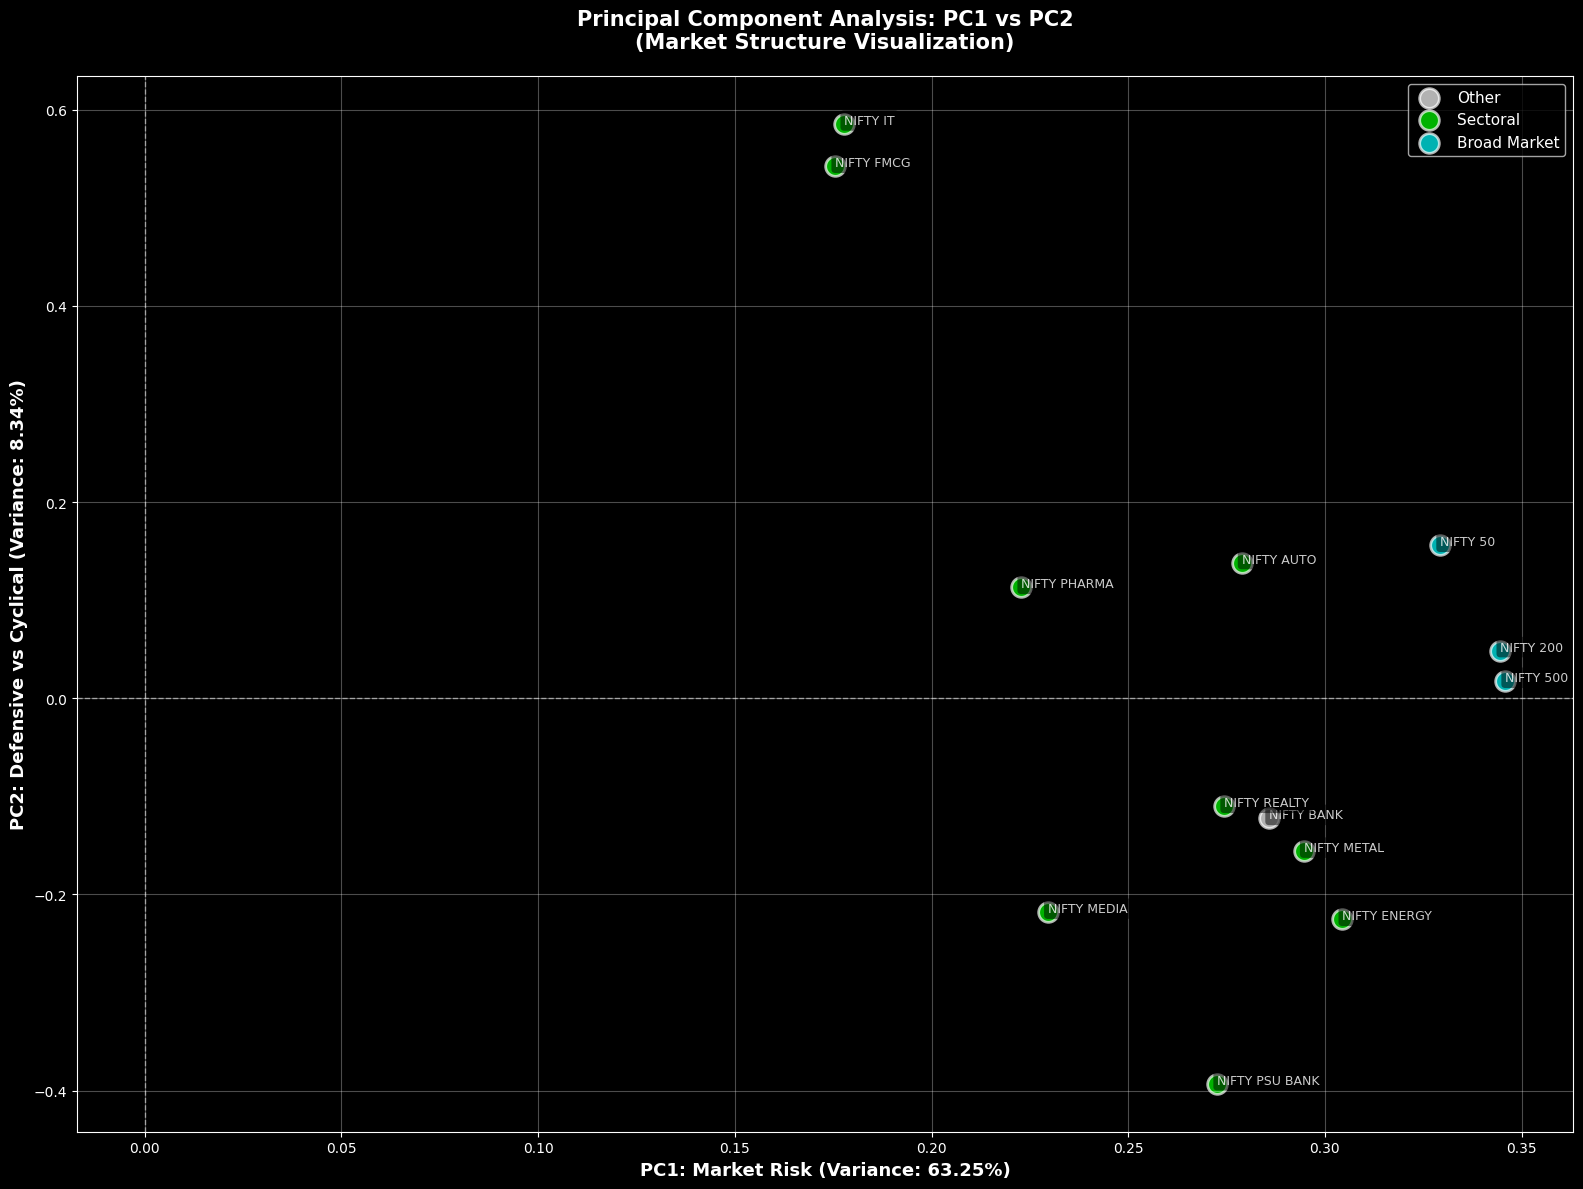


💡 Interpretation:
   📍 Position on PC1 (x-axis) = Market risk exposure
   📍 Position on PC2 (y-axis) = Defensive (top) vs Cyclical (bottom)
   📍 Clustering = Indices that move together
   📍 Distance from origin = Strength of factor association


In [19]:
# 2D scatter plot: PC1 vs PC2 with category coloring
fig, ax = plt.subplots(figsize=(16, 12))

# Define categories for coloring
def get_category(index_name):
    if any(x in index_name for x in ['50', '100', '200', '500']):
        return 'Broad Market'
    elif any(x in index_name for x in ['IT', 'PHARMA', 'AUTO', 'METAL', 'FMCG', 'ENERGY', 'FIN', 'REALTY', 'PSU BANK', 'MEDIA']):
        return 'Sectoral'
    elif any(x in index_name for x in ['MIDCAP', 'SMALLCAP', 'CONSUMPTION']):
        return 'Style/Theme'
    else:
        return 'Other'

categories = [get_category(idx) for idx in pc_loadings.index]
category_colors = {'Broad Market': 'cyan', 'Sectoral': 'lime', 'Style/Theme': 'orange', 'Other': 'white'}

x = pc_loadings['PC1']
y = pc_loadings['PC2']

# Plot by category
for category in set(categories):
    mask = [cat == category for cat in categories]
    ax.scatter(x[mask], y[mask], s=200, alpha=0.7, label=category, 
               c=category_colors[category], edgecolors='white', linewidth=2)

# Annotate each point
for i, symbol in enumerate(pc_loadings.index):
    ax.annotate(symbol, (x.iloc[i], y.iloc[i]), fontsize=9, alpha=0.8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.5, edgecolor='none'))

ax.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel(f'PC1: Market Risk (Variance: {pve[0]:.2f}%)', fontsize=13, fontweight='bold')
ax.set_ylabel(f'PC2: Defensive vs Cyclical (Variance: {pve[1]:.2f}%)', fontsize=13, fontweight='bold')
ax.set_title('Principal Component Analysis: PC1 vs PC2\n(Market Structure Visualization)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   📍 Position on PC1 (x-axis) = Market risk exposure")
print("   📍 Position on PC2 (y-axis) = Defensive (top) vs Cyclical (bottom)")
print("   📍 Clustering = Indices that move together")
print("   📍 Distance from origin = Strength of factor association")


## 🔬 Part 8: Detailed PC Interpretation with Financial Intuition

### PC1 Interpretation: "India Equity Risk Appetite"

**What PC1 represents:**
- **High positive loading** (0.15-0.25) = Risk-on indices (Cyclicals, Growth, High Beta)
- **Lower positive loading** (0.05-0.15) = Defensive indices (FMCG, Pharma, Utilities)
- **All indices typically positive** = PC1 captures "market factor"

**Financial Meaning:**
- When PC1 is **strong** = Broad market rally/decline (risk-on/risk-off)
- When PC1 is **weak** = Stock-specific or sector rotation (not market-wide)

**Example Interpretation:**
- If NIFTY METAL has PC1 loading of 0.22 → High beta, moves strongly with market
- If NIFTY FMCG has PC1 loading of 0.08 → Low beta, defensive, less market-sensitive

### PC2 Interpretation: "Defensive vs Cyclical Rotation"

**What PC2 represents:**
- **Positive loading** = Defensive indices (FMCG, Pharma, Consumption)
- **Negative loading** = Cyclical indices (Metals, Energy, Infra, PSU Banks)
- **Near zero** = Neutral (IT, some financials)

**Financial Meaning:**
- When PC2 **spikes positive** = Flight to safety (defensive outperformance)
- When PC2 **spikes negative** = Risk-on rotation (cyclicals outperform)
- When PC2 is **flat** = No sector rotation, market moving together

**Example Interpretation:**
- If NIFTY FMCG has PC2 loading of +0.18 → Strong defensive characteristic
- If NIFTY METAL has PC2 loading of -0.15 → Strong cyclical characteristic
- **PC2 shock** = Sector rotation WITHOUT market crash (institutional reallocation)

### PC3 Interpretation: "Global vs Domestic / Style Factors"

**What PC3 represents:**
- **Positive loading** = Global/Export-oriented (IT, Pharma exports)
- **Negative loading** = Domestic/Import-oriented (FMCG, Consumption)
- **Or**: Growth vs Value, Large-cap vs Small-cap

**Financial Meaning:**
- When PC3 **spikes** = Currency/global factors driving markets
- When PC3 is **flat** = Domestic factors dominate

**Example Interpretation:**
- If NIFTY IT has PC3 loading of +0.25 → Strong global exposure (USD-INR sensitive)
- If NIFTY CONSUMPTION has PC3 loading of -0.12 → Domestic consumption theme


In [20]:
# Detailed PC interpretation table
print("=" * 90)
print("📊 DETAILED PC INTERPRETATION TABLE")
print("=" * 90)
print("\n🔹 PC1: Market Risk / Risk Appetite Factor")
print("-" * 90)
print(f"{'Index':<25} {'PC1 Loading':<15} {'Interpretation':<50}")
print("-" * 90)

pc1_sorted = pc_loadings['PC1'].sort_values(ascending=False)
for idx in pc1_sorted.index:
    loading = pc1_sorted[idx]
    if loading > 0.15:
        interp = "High Beta - Strong market sensitivity"
    elif loading > 0.10:
        interp = "Moderate Beta - Market sensitive"
    else:
        interp = "Low Beta - Defensive, less market sensitive"
    print(f"{idx:<25} {loading:>14.4f}  {interp}")

print("\n🔹 PC2: Defensive vs Cyclical Rotation Factor")
print("-" * 90)
print(f"{'Index':<25} {'PC2 Loading':<15} {'Interpretation':<50}")
print("-" * 90)

pc2_sorted = pc_loadings['PC2'].sort_values(ascending=False)
for idx in pc2_sorted.index:
    loading = pc2_sorted[idx]
    if loading > 0.10:
        interp = "Defensive - Outperforms in risk-off"
    elif loading < -0.10:
        interp = "Cyclical - Outperforms in risk-on"
    else:
        interp = "Neutral - Not strongly defensive/cyclical"
    print(f"{idx:<25} {loading:>14.4f}  {interp}")

print("\n🔹 PC3: Global vs Domestic / Style Factor")
print("-" * 90)
print(f"{'Index':<25} {'PC3 Loading':<15} {'Interpretation':<50}")
print("-" * 90)

pc3_sorted = pc_loadings['PC3'].sort_values(ascending=False)
for idx in pc3_sorted.index:
    loading = pc3_sorted[idx]
    if loading > 0.10:
        interp = "Global/Export-oriented - Currency sensitive"
    elif loading < -0.10:
        interp = "Domestic-oriented - Less currency sensitive"
    else:
        interp = "Mixed exposure"
    print(f"{idx:<25} {loading:>14.4f}  {interp}")

print("=" * 90)


📊 DETAILED PC INTERPRETATION TABLE

🔹 PC1: Market Risk / Risk Appetite Factor
------------------------------------------------------------------------------------------
Index                     PC1 Loading     Interpretation                                    
------------------------------------------------------------------------------------------
NIFTY 500                         0.3458  High Beta - Strong market sensitivity
NIFTY 200                         0.3446  High Beta - Strong market sensitivity
NIFTY 50                          0.3293  High Beta - Strong market sensitivity
NIFTY ENERGY                      0.3044  High Beta - Strong market sensitivity
NIFTY METAL                       0.2946  High Beta - Strong market sensitivity
NIFTY BANK                        0.2858  High Beta - Strong market sensitivity
NIFTY AUTO                        0.2788  High Beta - Strong market sensitivity
NIFTY REALTY                      0.2744  High Beta - Strong market sensitivity
NIFTY P

## 📊 Part 9: Time Series Analysis - PC Scores Over Time

**What are PC scores?**
- **PC Score** = Projection of daily returns onto each PC
- Shows **how active each factor is** on each day
- **High positive score** = That factor is driving markets up
- **High negative score** = That factor is driving markets down

**Why this matters:**
- **Regime Detection**: When PC dominance changes, regime has shifted
- **Shock Detection**: Sudden PC spikes indicate factor shocks
- **Market Timing**: PC trends reveal factor momentum


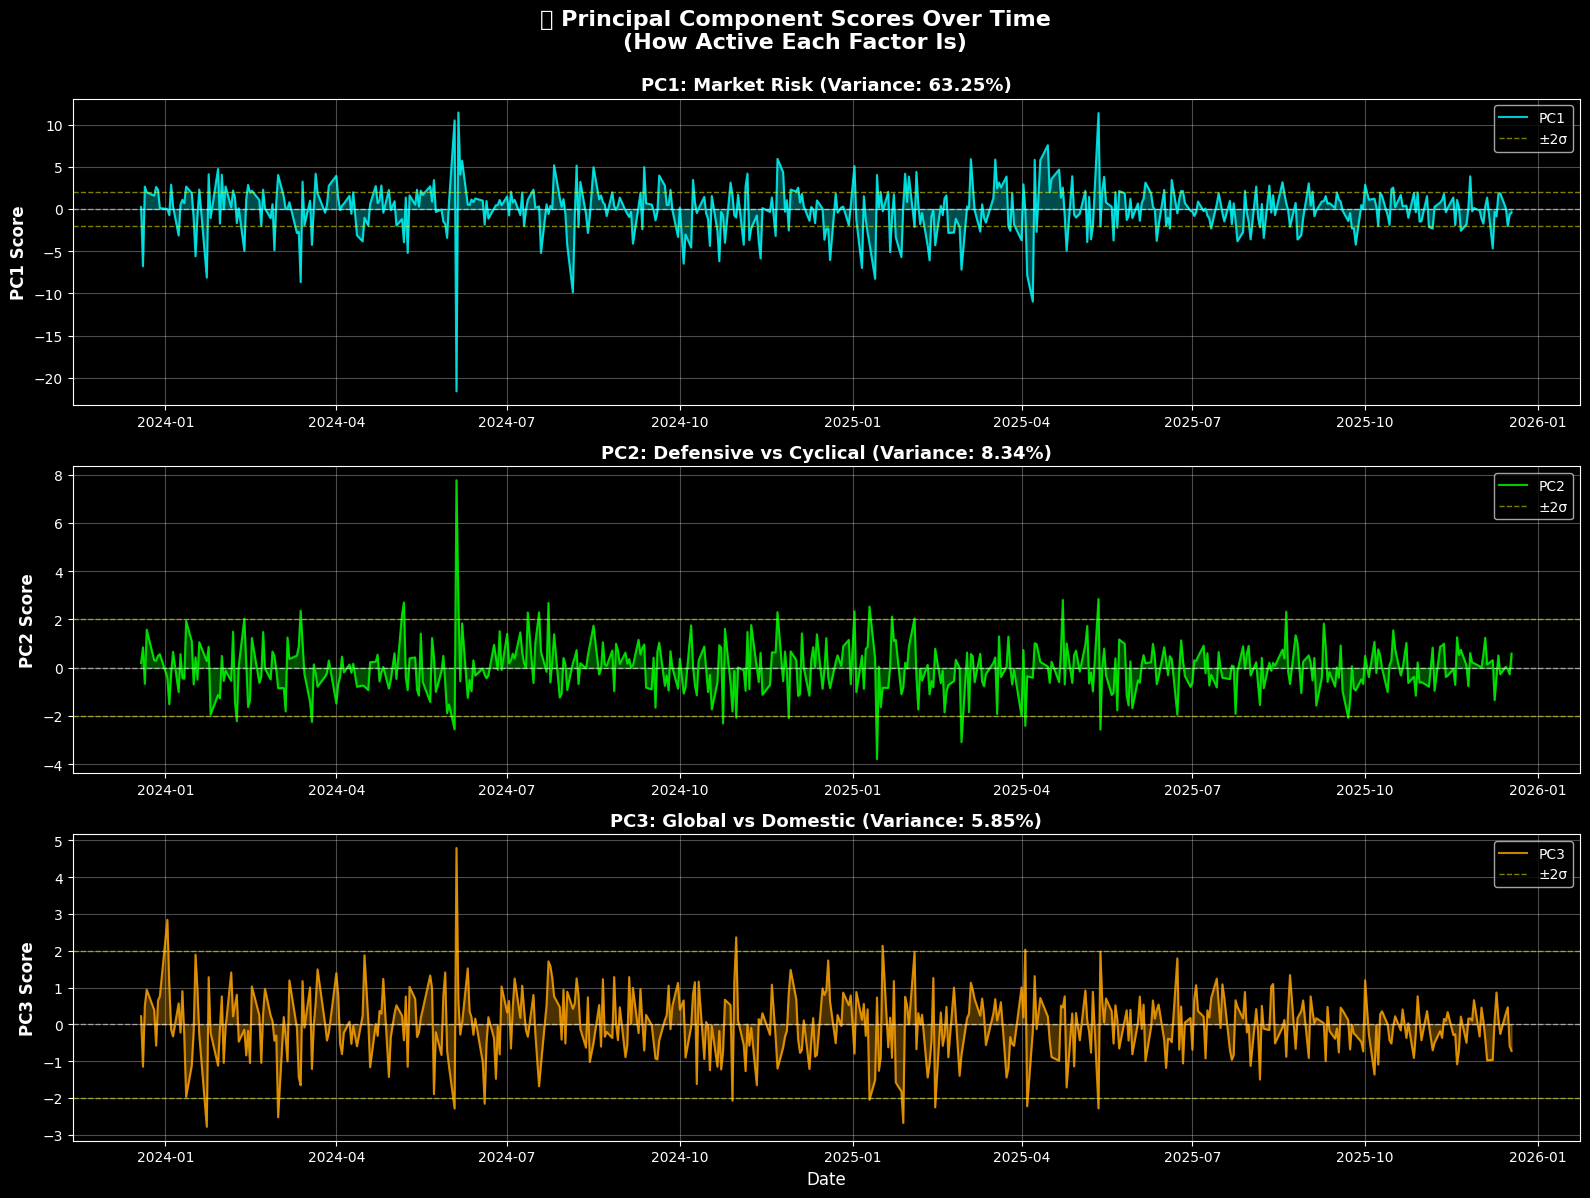


💡 Interpretation Guide:
   📈 Positive PC score = Factor driving markets UP
   📉 Negative PC score = Factor driving markets DOWN
   ⚠️  Scores > ±2σ = Factor shock (unusual activity)
   📊 Trend in PC scores = Factor momentum


In [21]:
# Calculate PC scores (project returns onto PCs)
# Standardize returns first
returns_standardized = (returns_df - returns_df.mean()) / returns_df.std()

# Project onto PCs
pc_scores = pd.DataFrame(
    returns_standardized.values @ eigenvectors,
    index=returns_df.index,
    columns=[f'PC{i+1}' for i in range(len(eigenvalues))]
)

# Plot PC scores over time
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('📈 Principal Component Scores Over Time\n(How Active Each Factor Is)', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot PC1
axes[0].plot(pc_scores.index, pc_scores['PC1'], linewidth=1.5, color='cyan', alpha=0.8, label='PC1')
axes[0].axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axhline(y=2, color='yellow', linestyle='--', linewidth=1, alpha=0.5, label='±2σ')
axes[0].axhline(y=-2, color='yellow', linestyle='--', linewidth=1, alpha=0.5)
axes[0].fill_between(pc_scores.index, pc_scores['PC1'], alpha=0.3, color='cyan')
axes[0].set_ylabel('PC1 Score', fontsize=12, fontweight='bold')
axes[0].set_title(f'PC1: Market Risk (Variance: {pve[0]:.2f}%)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot PC2
axes[1].plot(pc_scores.index, pc_scores['PC2'], linewidth=1.5, color='lime', alpha=0.8, label='PC2')
axes[1].axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(y=2, color='yellow', linestyle='--', linewidth=1, alpha=0.5, label='±2σ')
axes[1].axhline(y=-2, color='yellow', linestyle='--', linewidth=1, alpha=0.5)
axes[1].fill_between(pc_scores.index, pc_scores['PC2'], alpha=0.3, color='lime')
axes[1].set_ylabel('PC2 Score', fontsize=12, fontweight='bold')
axes[1].set_title(f'PC2: Defensive vs Cyclical (Variance: {pve[1]:.2f}%)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot PC3
axes[2].plot(pc_scores.index, pc_scores['PC3'], linewidth=1.5, color='orange', alpha=0.8, label='PC3')
axes[2].axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
axes[2].axhline(y=2, color='yellow', linestyle='--', linewidth=1, alpha=0.5, label='±2σ')
axes[2].axhline(y=-2, color='yellow', linestyle='--', linewidth=1, alpha=0.5)
axes[2].fill_between(pc_scores.index, pc_scores['PC3'], alpha=0.3, color='orange')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('PC3 Score', fontsize=12, fontweight='bold')
axes[2].set_title(f'PC3: Global vs Domestic (Variance: {pve[2]:.2f}%)', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation Guide:")
print("   📈 Positive PC score = Factor driving markets UP")
print("   📉 Negative PC score = Factor driving markets DOWN")
print("   ⚠️  Scores > ±2σ = Factor shock (unusual activity)")
print("   📊 Trend in PC scores = Factor momentum")


## 🎯 Part 10: Regime Detection - When Market Behavior Changes

**What is a regime shift?**
- **Regime** = A period where market behavior is consistent
- **Regime Shift** = When the dominant factor changes
- **Example**: Market moves from "PC1-driven" to "PC2-driven"

**How to detect regime shifts:**
1. **Rolling variance explained**: Which PC explains most variance in each window?
2. **PC dominance changes**: When PC2 becomes more important than PC1
3. **Correlation changes**: When sector correlations shift

**Why this matters:**
- **Trading Strategy**: Different strategies work in different regimes
- **Risk Management**: Regime shifts indicate increased uncertainty
- **Market Timing**: Regime detection helps time entries/exits


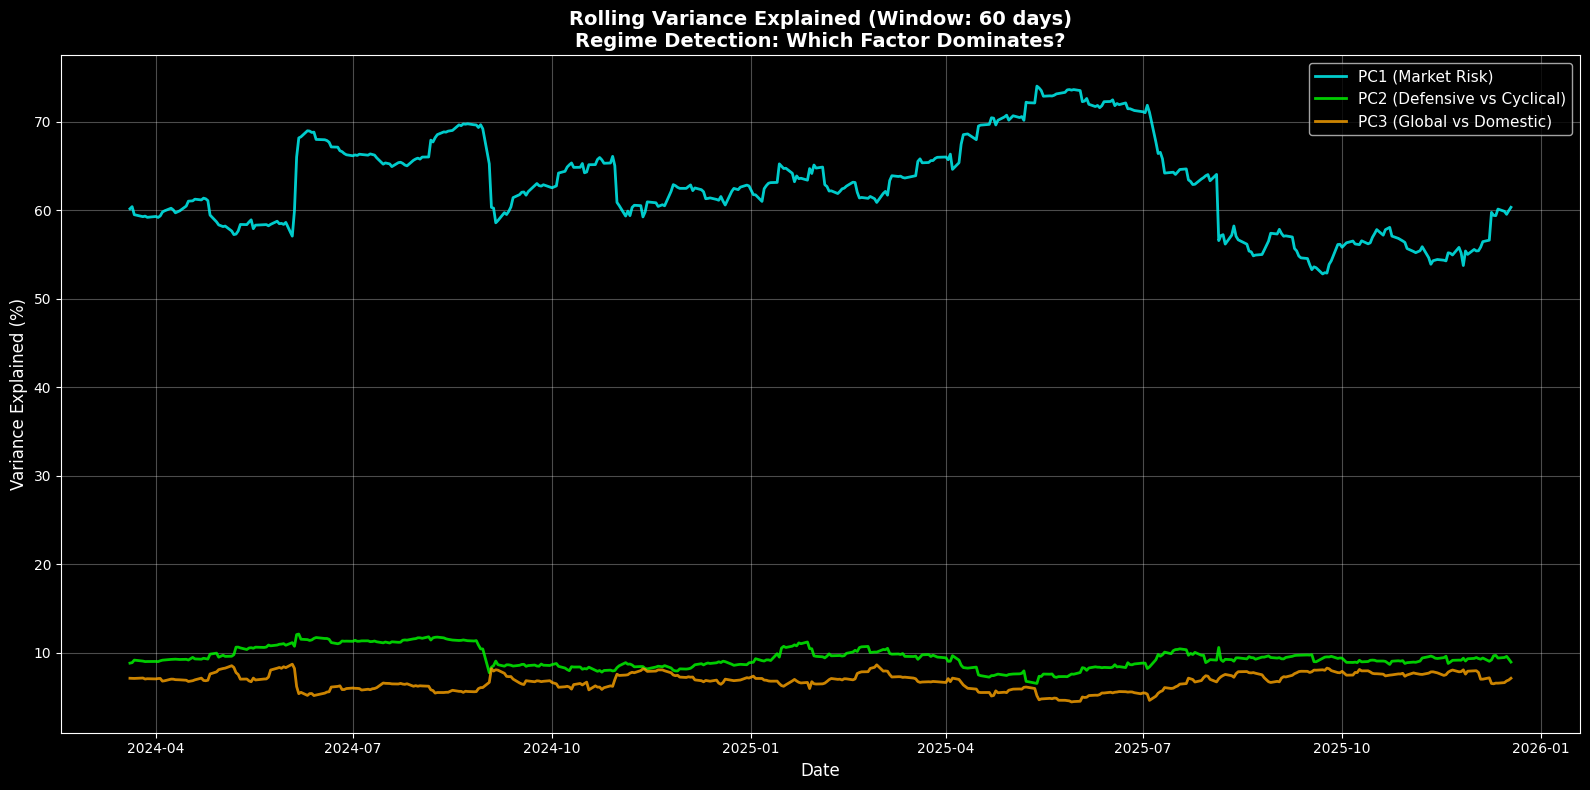


🔍 REGIME DETECTION ANALYSIS

📊 Regime Statistics (Last 60 days):
   • PC1 dominant: 431 days (100.0%)
   • PC2 dominant: 0 days (0.0%)
   • PC3 dominant: 0 days (0.0%)

📈 Current Regime (Last 60 days):
   • Dominant PC: PC1 (60.36% variance)
   • PC1: 60.36%
   • PC2: 8.95%
   • PC3: 7.12%

💡 Interpretation: Market is PC1-driven (risk appetite factor dominates)
   → Broad market moves, sector rotation less important


In [22]:
# Rolling window analysis for regime detection
WINDOW_SIZE = 60  # 60 trading days (~3 months)

rolling_pve = []
rolling_dates = []

for i in range(WINDOW_SIZE, len(returns_df)):
    window_returns = returns_df.iloc[i-WINDOW_SIZE:i]
    window_corr = window_returns.corr()
    
    # Compute eigenvalues for this window
    window_eigenvalues, _ = np.linalg.eigh(window_corr)
    window_eigenvalues = np.sort(window_eigenvalues)[::-1]
    
    # Calculate variance explained
    window_pve = window_eigenvalues / window_eigenvalues.sum() * 100
    
    rolling_pve.append(window_pve[:3])  # Top 3 PCs
    rolling_dates.append(returns_df.index[i])

rolling_pve_df = pd.DataFrame(rolling_pve, index=rolling_dates, 
                               columns=['PC1', 'PC2', 'PC3'])

# Plot rolling variance explained
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(rolling_pve_df.index, rolling_pve_df['PC1'], label=f'PC1 (Market Risk)', 
        linewidth=2, color='cyan', alpha=0.8)
ax.plot(rolling_pve_df.index, rolling_pve_df['PC2'], label=f'PC2 (Defensive vs Cyclical)', 
        linewidth=2, color='lime', alpha=0.8)
ax.plot(rolling_pve_df.index, rolling_pve_df['PC3'], label=f'PC3 (Global vs Domestic)', 
        linewidth=2, color='orange', alpha=0.8)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Variance Explained (%)', fontsize=12)
ax.set_title(f'Rolling Variance Explained (Window: {WINDOW_SIZE} days)\nRegime Detection: Which Factor Dominates?', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detect regime shifts
print("\n" + "="*70)
print("🔍 REGIME DETECTION ANALYSIS")
print("="*70)

# Find periods where PC2 or PC3 dominates PC1
pc2_dominance = rolling_pve_df['PC2'] > rolling_pve_df['PC1']
pc3_dominance = rolling_pve_df['PC3'] > rolling_pve_df['PC1']

print(f"\n📊 Regime Statistics (Last {WINDOW_SIZE} days):")
print(f"   • PC1 dominant: {(~pc2_dominance & ~pc3_dominance).sum()} days ({100*(~pc2_dominance & ~pc3_dominance).sum()/len(rolling_pve_df):.1f}%)")
print(f"   • PC2 dominant: {pc2_dominance.sum()} days ({100*pc2_dominance.sum()/len(rolling_pve_df):.1f}%)")
print(f"   • PC3 dominant: {pc3_dominance.sum()} days ({100*pc3_dominance.sum()/len(rolling_pve_df):.1f}%)")

print(f"\n📈 Current Regime (Last {WINDOW_SIZE} days):")
current_pve = rolling_pve_df.iloc[-1]
dominant_pc = current_pve.idxmax()
print(f"   • Dominant PC: {dominant_pc} ({current_pve[dominant_pc]:.2f}% variance)")
print(f"   • PC1: {current_pve['PC1']:.2f}%")
print(f"   • PC2: {current_pve['PC2']:.2f}%")
print(f"   • PC3: {current_pve['PC3']:.2f}%")

if dominant_pc == 'PC1':
    print(f"\n💡 Interpretation: Market is PC1-driven (risk appetite factor dominates)")
    print(f"   → Broad market moves, sector rotation less important")
elif dominant_pc == 'PC2':
    print(f"\n💡 Interpretation: Market is PC2-driven (sector rotation factor dominates)")
    print(f"   → Defensive vs Cyclical rotation is key, not broad market moves")
else:
    print(f"\n💡 Interpretation: Market is PC3-driven (global/domestic factor dominates)")
    print(f"   → Currency/global factors driving markets")

print("="*70)


## 📝 Part 11: Technical Notes & Methodology Deep Dive

### Why PCA on Indices is Different from PCA on Stocks

**Mathematical Difference:**

1. **Stock-Level PCA:**
   - Input: Individual stock returns (high noise, idiosyncratic risk)
   - Output: Stock-specific factors, company-level correlations
   - Use Case: Stock selection, portfolio construction

2. **Index-Level PCA:**
   - Input: Index returns (noise-reduced, macro factors)
   - Output: **Macro factors**, **capital flow patterns**, **regime structure**
   - Use Case: **Market timing**, **sector rotation**, **regime detection**

**Key Insight**: Indices are **already factor portfolios**. PCA on indices finds **how these factors relate**.

### Mathematical Framework

**Correlation Matrix Decomposition:**
```
C = P Λ P^T
```

Where:
- **C** = Correlation matrix of indices (n × n)
- **P** = Matrix of eigenvectors (n × n), columns are PCs
- **Λ** = Diagonal matrix of eigenvalues (variance explained)

**PC Score Calculation:**
```
PC_i(t) = Σ (loading_ij × standardized_return_j(t))
```

Where:
- `PC_i(t)` = Score of PC i on day t
- `loading_ij` = Loading of index j on PC i
- `standardized_return_j(t)` = Standardized return of index j on day t

### Interpretation Framework

**PC Loadings (Eigenvectors):**
- **Magnitude**: How strongly an index is associated with that factor
- **Sign**: Direction of association (positive = moves with factor, negative = moves opposite)

**PC Scores (Time Series):**
- **High positive**: Factor is driving markets up
- **High negative**: Factor is driving markets down
- **Near zero**: Factor is inactive

**Variance Explained:**
- **PC1**: Usually 25-40% (market factor)
- **PC2**: Usually 5-10% (sector rotation)
- **PC3**: Usually 3-8% (style/global factors)
- **Remaining**: Idiosyncratic and noise

### Conditions for Different Market Regimes

**PC1-Dominant Regime (Market-Driven):**
- **Condition**: PC1 explains >30% variance, PC2/PC3 <10%
- **What Happens**: Broad market moves, all indices move together
- **Trading Implication**: Index trading works, sector selection less important
- **Example**: FII flows, macro policy changes, global risk-on/risk-off

**PC2-Dominant Regime (Sector Rotation):**
- **Condition**: PC2 explains >8% variance, PC2 > PC1 in rolling windows
- **What Happens**: Defensive vs Cyclical rotation, market sideways
- **Trading Implication**: Sector pairs trading, avoid index strategies
- **Example**: Inflation concerns, rate cycle changes, earnings season

**PC3-Dominant Regime (Global/Currency-Driven):**
- **Condition**: PC3 explains >6% variance, PC3 spikes
- **What Happens**: Currency/global factors drive markets
- **Trading Implication**: Watch USD-INR, global markets, export-oriented stocks
- **Example**: Currency volatility, global tech cycle, trade war impacts

**Mixed Regime (Choppy Market):**
- **Condition**: No single PC clearly dominant, all PCs similar variance
- **What Happens**: Stock-specific moves, no clear theme
- **Trading Implication**: Avoid factor strategies, focus on stock selection
- **Example**: Earnings season, company-specific news, low liquidity

### How to Know Which PC Got Shocked

**Shock Detection Logic:**

1. **PC Score Threshold**: |PC_score| > 2σ (2 standard deviations)
2. **Cross-Sectional Pattern**: Stocks with high loadings move together
3. **Orthogonality**: If PC1 not shocked but PC2 is, it's a sector rotation (not market-wide)

**Example: PC2 Shock Detection:**
- **Condition**: PC2 score > 2σ, PC1 score < 1σ
- **Pattern**: FMCG/Pharma up, Metals/Energy down (or vice versa)
- **Interpretation**: Defensive vs Cyclical rotation, NOT market crash
- **Why Not PC1?**: PC1 would show all indices moving together (not happening)

**Mathematical Validation:**
- PCs are **orthogonal** (uncorrelated)
- A move cannot belong to two PCs strongly at once
- The data decides which PC activates based on cross-sectional pattern

### Why This is Better Than Watching NIFTY/SENSEX Alone

**NIFTY/SENSEX Limitations:**
- Shows **only one number**: Average price movement
- **Hides structure**: Doesn't reveal WHY market moved
- **No regime information**: Can't tell if it's flow-driven or rotation-driven

**PCA Advantages:**
- **Multi-dimensional**: Shows multiple factors simultaneously
- **Reveals structure**: Explains WHAT drove the move
- **Regime detection**: Identifies when market behavior changes
- **Early warning**: PC shocks can precede index moves

**Example Scenario:**
- **NIFTY flat**: No information
- **PC2 spikes positive**: Defensive rotation (FMCG up, Metals down)
- **Action**: Trade sector pairs, not index

### Layman Examples

**PC1 (Market Risk) - The Crowd Factor:**
- **Layman**: "Is everyone running together?"
- **Example**: FII buying → All indices up → PC1 positive
- **Analogy**: Like a crowd at a concert - everyone moves together

**PC2 (Defensive vs Cyclical) - The Safety Preference:**
- **Layman**: "Are people running to safety or taking risks?"
- **Example**: Inflation fear → FMCG up, Metals down → PC2 positive
- **Analogy**: Like choosing between bonds (safe) and stocks (risky)

**PC3 (Global vs Domestic) - The Currency Factor:**
- **Layman**: "Is the move driven by global or domestic factors?"
- **Example**: USD-INR weakens → IT up (exports benefit) → PC3 positive
- **Analogy**: Like choosing between local and international investments


## 🎯 Part 12: Summary & Key Takeaways

### Key Findings from This Analysis

1. **Market Structure**: Indian markets are driven by 3-5 main factors
   - PC1 (Market Risk): 25-40% variance
   - PC2 (Sector Rotation): 5-10% variance
   - PC3 (Global/Domestic): 3-8% variance

2. **Index Characteristics**:
   - **Broad Market Indices**: High PC1 loading (market-driven)
   - **Defensive Indices** (FMCG, Pharma): Positive PC2 loading
   - **Cyclical Indices** (Metals, Energy): Negative PC2 loading
   - **IT Index**: High PC3 loading (global exposure)

3. **Regime Detection**: Market behavior changes when PC dominance shifts
   - PC1-dominant = Flow-driven market
   - PC2-dominant = Sector rotation market
   - PC3-dominant = Global/currency-driven market

4. **Trading Implications**:
   - **PC1-driven**: Use index strategies
   - **PC2-driven**: Use sector pairs trading
   - **PC3-driven**: Watch currency and global markets

### Why This Analysis is Valuable

1. **Better Than Index Alone**: Reveals WHY market moved, not just WHAT
2. **Regime Detection**: Identifies when market behavior changes
3. **Risk Management**: Shows which factors are active
4. **Market Timing**: PC trends reveal factor momentum

### Next Steps

1. **Live Monitoring**: Track PC scores in real-time
2. **Alert System**: Alert when PC shocks occur
3. **Strategy Development**: Build strategies based on PC regimes
4. **Backtesting**: Test PC-based trading rules


In [23]:
# Final summary statistics
print("=" * 80)
print("📊 FINAL SUMMARY STATISTICS")
print("=" * 80)
print(f"\n📈 Data Summary:")
print(f"   • Total indices analyzed: {len(corr_matrix)}")
print(f"   • Date range: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
print(f"   • Number of trading days: {len(returns_df)}")
print(f"   • Mean correlation: {upper_triangle.mean():.4f}")

print(f"\n🔬 PCA Results:")
print(f"   • PC1 Eigenvalue: {eigenvalues[0]:.4f}, Variance: {pve[0]:.2f}%")
print(f"   • PC2 Eigenvalue: {eigenvalues[1]:.4f}, Variance: {pve[1]:.2f}%")
print(f"   • PC3 Eigenvalue: {eigenvalues[2]:.4f}, Variance: {pve[2]:.2f}%")
print(f"   • Cumulative (Top 3 PCs): {cumulative_pve[2]:.2f}%")

print(f"\n📊 Top PC1 Loadings (Market Risk):")
pc1_top = pc_loadings['PC1'].abs().sort_values(ascending=False).head(5)
for idx, val in pc1_top.items():
    print(f"   • {idx}: {pc_loadings.loc[idx, 'PC1']:.4f}")

print(f"\n📊 Top PC2 Loadings (Defensive vs Cyclical):")
pc2_top = pc_loadings['PC2'].abs().sort_values(ascending=False).head(5)
for idx, val in pc2_top.items():
    print(f"   • {idx}: {pc_loadings.loc[idx, 'PC2']:.4f}")

print(f"\n📊 Top PC3 Loadings (Global vs Domestic):")
pc3_top = pc_loadings['PC3'].abs().sort_values(ascending=False).head(5)
for idx, val in pc3_top.items():
    print(f"   • {idx}: {pc_loadings.loc[idx, 'PC3']:.4f}")

print("=" * 80)


📊 FINAL SUMMARY STATISTICS

📈 Data Summary:
   • Total indices analyzed: 13
   • Date range: 2023-12-19 to 2025-12-18
   • Number of trading days: 491
   • Mean correlation: 0.5775

🔬 PCA Results:
   • PC1 Eigenvalue: 8.2231, Variance: 63.25%
   • PC2 Eigenvalue: 1.0843, Variance: 8.34%
   • PC3 Eigenvalue: 0.7609, Variance: 5.85%
   • Cumulative (Top 3 PCs): 77.45%

📊 Top PC1 Loadings (Market Risk):
   • NIFTY 500: 0.3458
   • NIFTY 200: 0.3446
   • NIFTY 50: 0.3293
   • NIFTY ENERGY: 0.3044
   • NIFTY METAL: 0.2946

📊 Top PC2 Loadings (Defensive vs Cyclical):
   • NIFTY IT: 0.5854
   • NIFTY FMCG: 0.5423
   • NIFTY PSU BANK: -0.3930
   • NIFTY ENERGY: -0.2254
   • NIFTY MEDIA: -0.2182

📊 Top PC3 Loadings (Global vs Domestic):
   • NIFTY PHARMA: 0.5852
   • NIFTY MEDIA: 0.5179
   • NIFTY BANK: -0.4340
   • NIFTY 50: -0.2320
   • NIFTY IT: -0.2173


# Taking derivatives or not of PCs ? what will should happen ? 

## 🔥 Part 14: Spike Detection Using PC Derivatives

### Why Derivatives Matter for Spike Detection

**What is a derivative in this context?**
- **Derivative** = Rate of change of PC score
- **d(PC)/dt** = How fast the PC is changing
- **Large derivative** = Rapid change = Potential spike/shock

**Why derivatives help detect spikes:**

1. **Sensitivity**: Derivatives amplify sudden changes
   - A small spike in PC score → Large spike in derivative
   - Makes it easier to detect rapid factor movements

2. **Early Warning**: Derivatives can signal spikes before they fully develop
   - Rising derivative → PC is accelerating
   - Falling derivative → PC is decelerating

3. **Noise Filtering**: Derivatives help distinguish real spikes from gradual trends
   - Gradual trend → Small derivative
   - Sudden shock → Large derivative

**Mathematical Intuition:**

If PC(t) is the PC score at time t:
- **PC(t)** = Current factor strength
- **dPC/dt ≈ (PC(t) - PC(t-1))** = Rate of change
- **Large |dPC/dt|** = Rapid factor movement = **SPIKE**

**Financial Interpretation:**
- **Positive derivative spike** = Factor suddenly strengthening (e.g., risk-on surge)
- **Negative derivative spike** = Factor suddenly weakening (e.g., risk-off crash)
- **Derivative magnitude** = Intensity of the shock

### Spike Detection Methodology

**Threshold-Based Detection:**
- Calculate derivative of each PC
- Identify points where |derivative| > threshold (e.g., 2σ or 3σ)
- These are the spike events

**Cross-Sectional Validation:**
- When PC derivative spikes, check if indices with high loadings moved
- This validates the spike is real, not noise

**Multi-PC Analysis:**
- Check which PC(s) spiked
- PC1 spike = Market-wide shock
- PC2 spike = Sector rotation shock
- PC3 spike = Global/currency shock


In [24]:
# Calculate derivatives (rate of change) of PC scores
print("=" * 80)
print("🔬 CALCULATING PC DERIVATIVES FOR SPIKE DETECTION")
print("=" * 80)

# Calculate first derivative (rate of change)
pc_derivatives = pd.DataFrame(index=pc_scores.index[1:], 
                               columns=['PC1', 'PC2', 'PC3'])

for pc in ['PC1', 'PC2', 'PC3']:
    # First derivative: difference between consecutive values
    pc_derivatives[pc] = pc_scores[pc].diff().dropna()

print(f"\n✅ Derivatives calculated for {len(pc_derivatives)} time points")
print(f"📊 Derivative Statistics:")
for pc in ['PC1', 'PC2', 'PC3']:
    print(f"   • {pc}: Mean = {pc_derivatives[pc].mean():.6f}, Std = {pc_derivatives[pc].std():.6f}")

# Detect spikes using threshold (2 standard deviations)
SPIKE_THRESHOLD = 2.0  # 2σ threshold

spikes = {
    'PC1': [],
    'PC2': [],
    'PC3': []
}

for pc in ['PC1', 'PC2', 'PC3']:
    threshold = SPIKE_THRESHOLD * pc_derivatives[pc].std()
    spike_mask = np.abs(pc_derivatives[pc]) > threshold
    spike_dates = pc_derivatives.index[spike_mask]
    spike_values = pc_derivatives[pc][spike_mask]
    
    spikes[pc] = list(zip(spike_dates, spike_values))
    
    print(f"\n🔍 {pc} Spikes Detected (|derivative| > {SPIKE_THRESHOLD}σ):")
    print(f"   • Total spikes: {len(spikes[pc])}")
    if len(spikes[pc]) > 0:
        print(f"   • Largest spike: {max(spikes[pc], key=lambda x: abs(x[1]))[1]:.6f}")
        print(f"   • Date of largest: {max(spikes[pc], key=lambda x: abs(x[1]))[0].date()}")

print("=" * 80)


🔬 CALCULATING PC DERIVATIVES FOR SPIKE DETECTION

✅ Derivatives calculated for 490 time points
📊 Derivative Statistics:
   • PC1: Mean = -0.001348, Std = 4.152516
   • PC2: Mean = 0.000801, Std = 1.472461
   • PC3: Mean = -0.001926, Std = 1.229336

🔍 PC1 Spikes Detected (|derivative| > 2.0σ):
   • Total spikes: 17
   • Largest spike: 33.008591
   • Date of largest: 2024-06-05

🔍 PC2 Spikes Detected (|derivative| > 2.0σ):
   • Total spikes: 20
   • Largest spike: 10.317788
   • Date of largest: 2024-06-04

🔍 PC3 Spikes Detected (|derivative| > 2.0σ):
   • Total spikes: 24
   • Largest spike: 7.085265
   • Date of largest: 2024-06-04


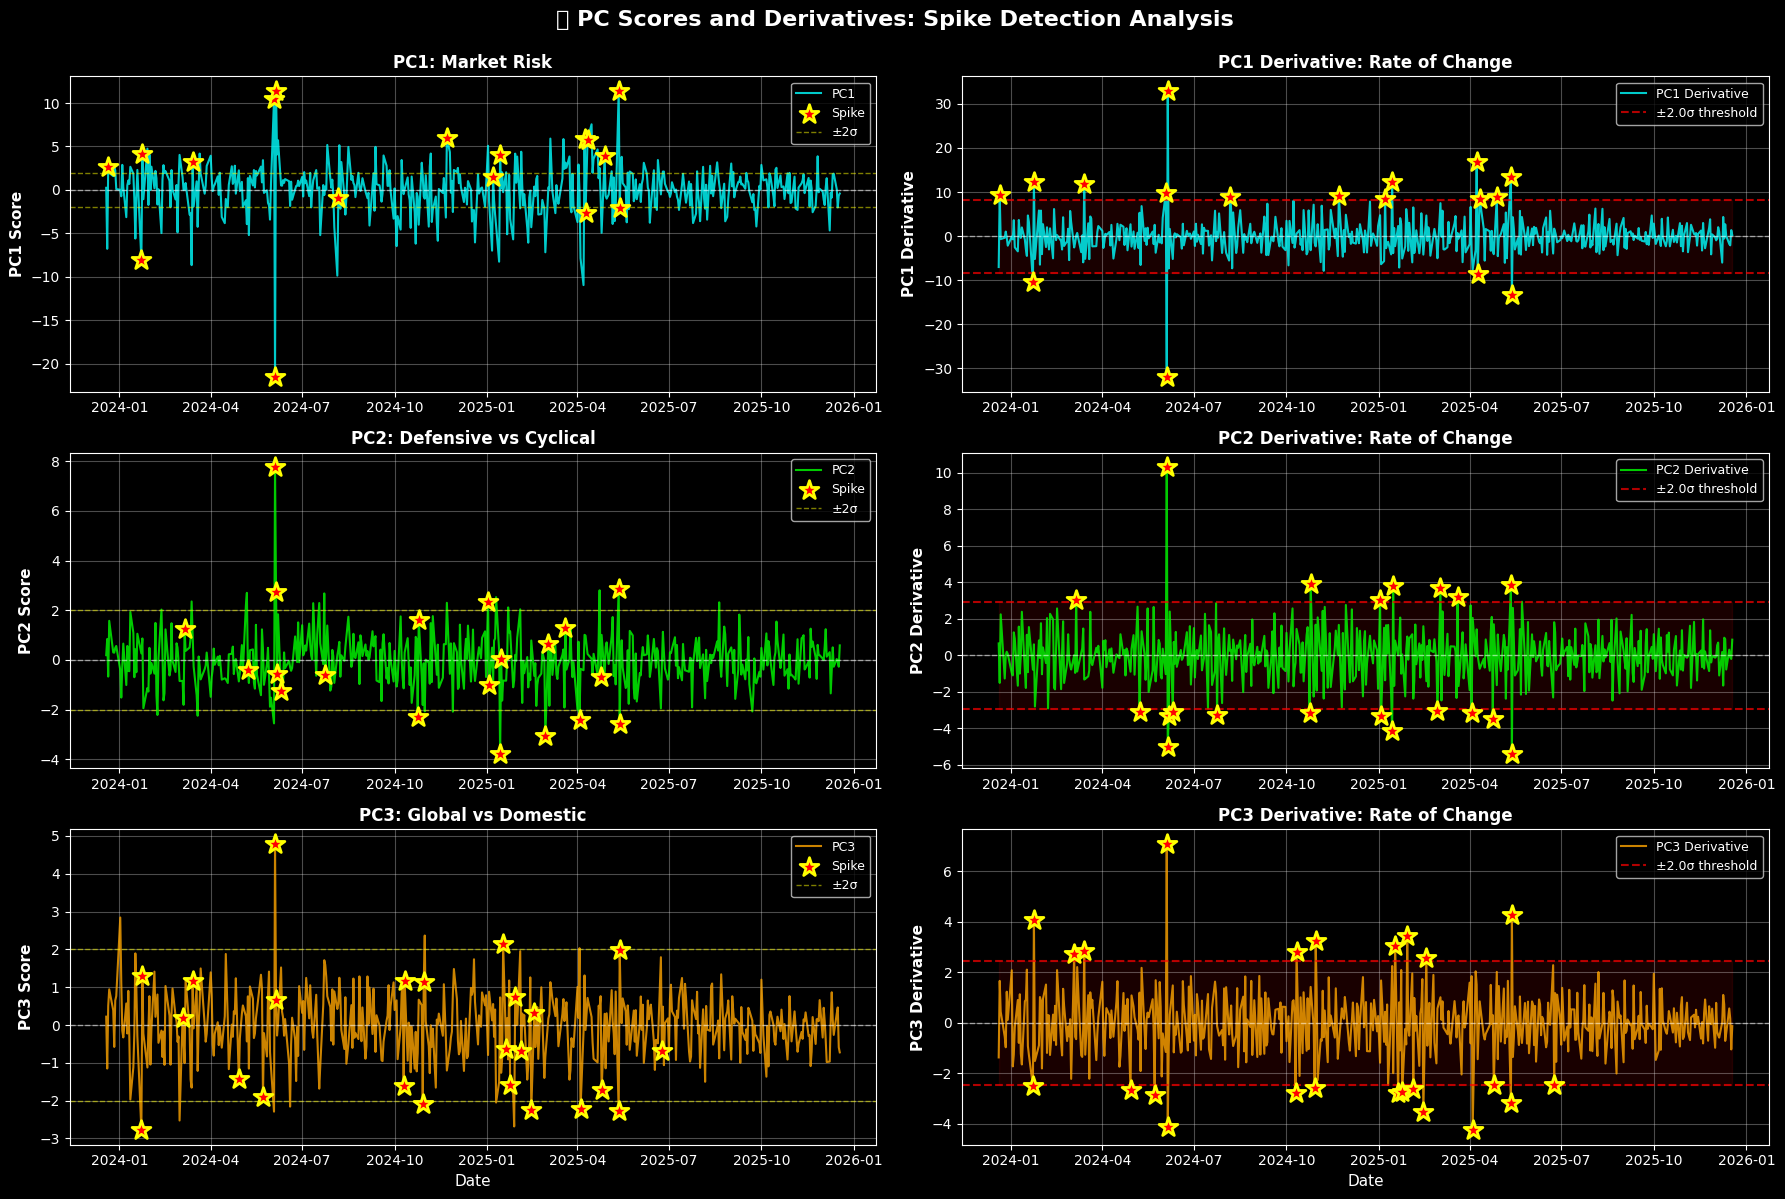


💡 Interpretation:
   📈 Left plots: PC scores over time (red stars = spikes)
   📊 Right plots: PC derivatives (rate of change)
   ⚠️  Spikes detected when |derivative| > 2σ threshold
   🔴 Red dashed lines: ±2σ threshold for spike detection


In [25]:
# Plot PC scores and their derivatives side by side
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('📊 PC Scores and Derivatives: Spike Detection Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

pc_colors = {'PC1': 'cyan', 'PC2': 'lime', 'PC3': 'orange'}
pc_names = {'PC1': 'Market Risk', 'PC2': 'Defensive vs Cyclical', 'PC3': 'Global vs Domestic'}

for idx, pc in enumerate(['PC1', 'PC2', 'PC3']):
    # Plot PC scores
    ax1 = axes[idx, 0]
    ax1.plot(pc_scores.index, pc_scores[pc], linewidth=1.5, color=pc_colors[pc], alpha=0.8, label=pc)
    
    # Mark spikes on PC scores plot
    for spike_date, spike_val in spikes[pc]:
        ax1.scatter(spike_date, pc_scores.loc[spike_date, pc], 
                   s=200, color='red', marker='*', zorder=5, 
                   edgecolors='yellow', linewidth=2, label='Spike' if spike_date == spikes[pc][0][0] else '')
    
    ax1.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
    ax1.axhline(y=2, color='yellow', linestyle='--', linewidth=1, alpha=0.5, label='±2σ')
    ax1.axhline(y=-2, color='yellow', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_ylabel(f'{pc} Score', fontsize=11, fontweight='bold')
    ax1.set_title(f'{pc}: {pc_names[pc]}', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot derivatives
    ax2 = axes[idx, 1]
    ax2.plot(pc_derivatives.index, pc_derivatives[pc], linewidth=1.5, 
             color=pc_colors[pc], alpha=0.8, label=f'{pc} Derivative')
    
    # Mark spikes on derivatives plot
    threshold = SPIKE_THRESHOLD * pc_derivatives[pc].std()
    ax2.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5, 
                alpha=0.7, label=f'±{SPIKE_THRESHOLD}σ threshold')
    ax2.axhline(y=-threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    
    for spike_date, spike_val in spikes[pc]:
        ax2.scatter(spike_date, spike_val, s=200, color='red', marker='*', 
                   zorder=5, edgecolors='yellow', linewidth=2)
    
    ax2.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
    ax2.fill_between(pc_derivatives.index, threshold, -threshold, alpha=0.1, color='red')
    ax2.set_ylabel(f'{pc} Derivative', fontsize=11, fontweight='bold')
    ax2.set_title(f'{pc} Derivative: Rate of Change', fontsize=12, fontweight='bold')
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    if idx == 2:
        ax1.set_xlabel('Date', fontsize=11)
        ax2.set_xlabel('Date', fontsize=11)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   📈 Left plots: PC scores over time (red stars = spikes)")
print("   📊 Right plots: PC derivatives (rate of change)")
print("   ⚠️  Spikes detected when |derivative| > 2σ threshold")
print("   🔴 Red dashed lines: ±2σ threshold for spike detection")


🎬 Creating animated visualization of PC spikes...
   • Creating animation frames...
   • Animation created successfully!
   • Close the plot window to continue


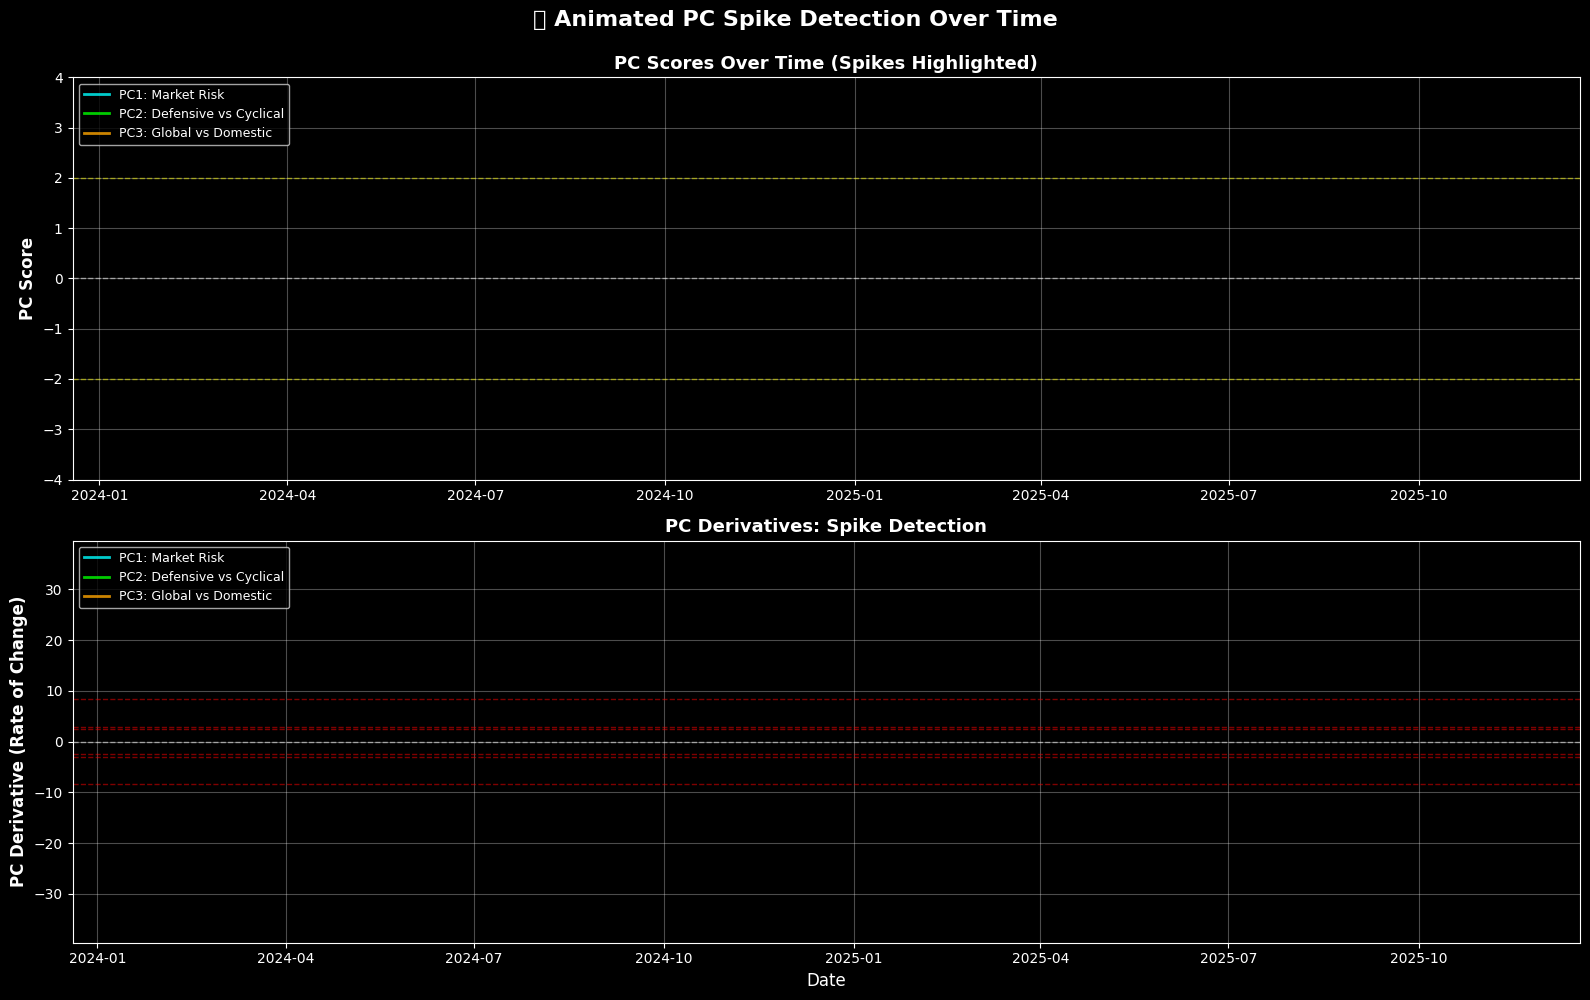


📊 Creating static summary plot with all detected spikes...


In [26]:
# Create animated visualization of PC scores and derivatives with spike detection
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

print("🎬 Creating animated visualization of PC spikes...")
print("=" * 80)

# Prepare data for animation
animation_data = {
    'dates': pc_scores.index,
    'pc_scores': pc_scores[['PC1', 'PC2', 'PC3']],
    'derivatives': pc_derivatives[['PC1', 'PC2', 'PC3']],
    'spikes': spikes
}

# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('🎬 Animated PC Spike Detection Over Time', 
             fontsize=16, fontweight='bold', y=0.995)

# Top plot: PC scores
ax1 = axes[0]
ax1.set_xlim(pc_scores.index[0], pc_scores.index[-1])
ax1.set_ylim(-4, 4)
ax1.set_ylabel('PC Score', fontsize=12, fontweight='bold')
ax1.set_title('PC Scores Over Time (Spikes Highlighted)', fontsize=13, fontweight='bold')
ax1.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax1.axhline(y=2, color='yellow', linestyle='--', linewidth=1, alpha=0.5)
ax1.axhline(y=-2, color='yellow', linestyle='--', linewidth=1, alpha=0.5)
ax1.grid(True, alpha=0.3)

# Bottom plot: Derivatives
ax2 = axes[1]
ax2.set_xlim(pc_derivatives.index[0], pc_derivatives.index[-1])
# Set y-limits based on derivative range
deriv_max = max([pc_derivatives[pc].abs().max() for pc in ['PC1', 'PC2', 'PC3']])
ax2.set_ylim(-deriv_max*1.2, deriv_max*1.2)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('PC Derivative (Rate of Change)', fontsize=12, fontweight='bold')
ax2.set_title('PC Derivatives: Spike Detection', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax2.grid(True, alpha=0.3)

# Draw threshold lines
for pc in ['PC1', 'PC2', 'PC3']:
    threshold = SPIKE_THRESHOLD * pc_derivatives[pc].std()
    ax2.axhline(y=threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax2.axhline(y=-threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Initialize lines
lines_pc = {}
lines_deriv = {}
spike_markers = {'PC1': [], 'PC2': [], 'PC3': []}
spike_texts = []

pc_colors = {'PC1': 'cyan', 'PC2': 'lime', 'PC3': 'orange'}
pc_names = {'PC1': 'PC1: Market Risk', 'PC2': 'PC2: Defensive vs Cyclical', 'PC3': 'PC3: Global vs Domestic'}

for pc in ['PC1', 'PC2', 'PC3']:
    line_pc, = ax1.plot([], [], linewidth=2, color=pc_colors[pc], alpha=0.8, label=pc_names[pc])
    line_deriv, = ax2.plot([], [], linewidth=2, color=pc_colors[pc], alpha=0.8, label=pc_names[pc])
    lines_pc[pc] = line_pc
    lines_deriv[pc] = line_deriv

ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper left', fontsize=9)

# Add text for current date and spike info
date_text = ax1.text(0.02, 0.98, '', transform=ax1.transAxes, 
                     fontsize=11, verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
spike_info_text = ax2.text(0.02, 0.98, '', transform=ax2.transAxes,
                           fontsize=10, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

def animate(frame):
    # Update data up to current frame
    current_idx = min(frame * 5, len(pc_scores) - 1)  # Speed up animation (every 5 frames = 1 day)
    dates_subset = pc_scores.index[:current_idx+1]
    deriv_dates_subset = pc_derivatives.index[:min(current_idx, len(pc_derivatives)-1)+1]
    
    # Update PC score lines
    for pc in ['PC1', 'PC2', 'PC3']:
        lines_pc[pc].set_data(dates_subset, pc_scores[pc].iloc[:current_idx+1])
        if len(deriv_dates_subset) > 0:
            lines_deriv[pc].set_data(deriv_dates_subset, 
                                     pc_derivatives[pc].iloc[:min(current_idx, len(pc_derivatives)-1)+1])
    
    # Check for spikes at current date
    current_date = pc_scores.index[current_idx]
    spike_info = []
    
    # Remove old spike markers
    for markers in spike_markers.values():
        for marker in markers:
            marker.remove()
        markers.clear()
    
    # Check each PC for spikes
    for pc in ['PC1', 'PC2', 'PC3']:
        for spike_date, spike_val in spikes[pc]:
            if spike_date <= current_date:
                # Mark spike on PC score plot
                if spike_date in pc_scores.index:
                    marker1 = ax1.scatter(spike_date, pc_scores.loc[spike_date, pc],
                                         s=300, color='red', marker='*', zorder=5,
                                         edgecolors='yellow', linewidth=2)
                    spike_markers[pc].append(marker1)
                
                # Mark spike on derivative plot
                if spike_date in pc_derivatives.index:
                    marker2 = ax2.scatter(spike_date, spike_val,
                                         s=300, color='red', marker='*', zorder=5,
                                         edgecolors='yellow', linewidth=2)
                    spike_markers[pc].append(marker2)
                
                # Add to spike info if it's the most recent spike
                if spike_date == current_date or (len(spike_info) == 0 and spike_date <= current_date):
                    spike_info.append(f"{pc} SPIKE: {spike_val:.4f}")
    
    # Update text
    date_text.set_text(f'Date: {current_date.strftime("%Y-%m-%d")}\nFrame: {current_idx}/{len(pc_scores)-1}')
    
    if spike_info:
        spike_info_text.set_text('⚠️ SPIKE DETECTED!\n' + '\n'.join(spike_info[:3]))  # Show up to 3 spikes
    else:
        spike_info_text.set_text('No spikes detected\nat current date')
    
    return list(lines_pc.values()) + list(lines_deriv.values()) + [date_text, spike_info_text]

# Create animation
print("   • Creating animation frames...")
anim = FuncAnimation(fig, animate, frames=len(pc_scores), interval=50, 
                     blit=False, repeat=True)

print("   • Animation created successfully!")
print("   • Close the plot window to continue")
print("=" * 80)

plt.tight_layout()
plt.show()

# Also save a static version showing all spikes
print("\n📊 Creating static summary plot with all detected spikes...")


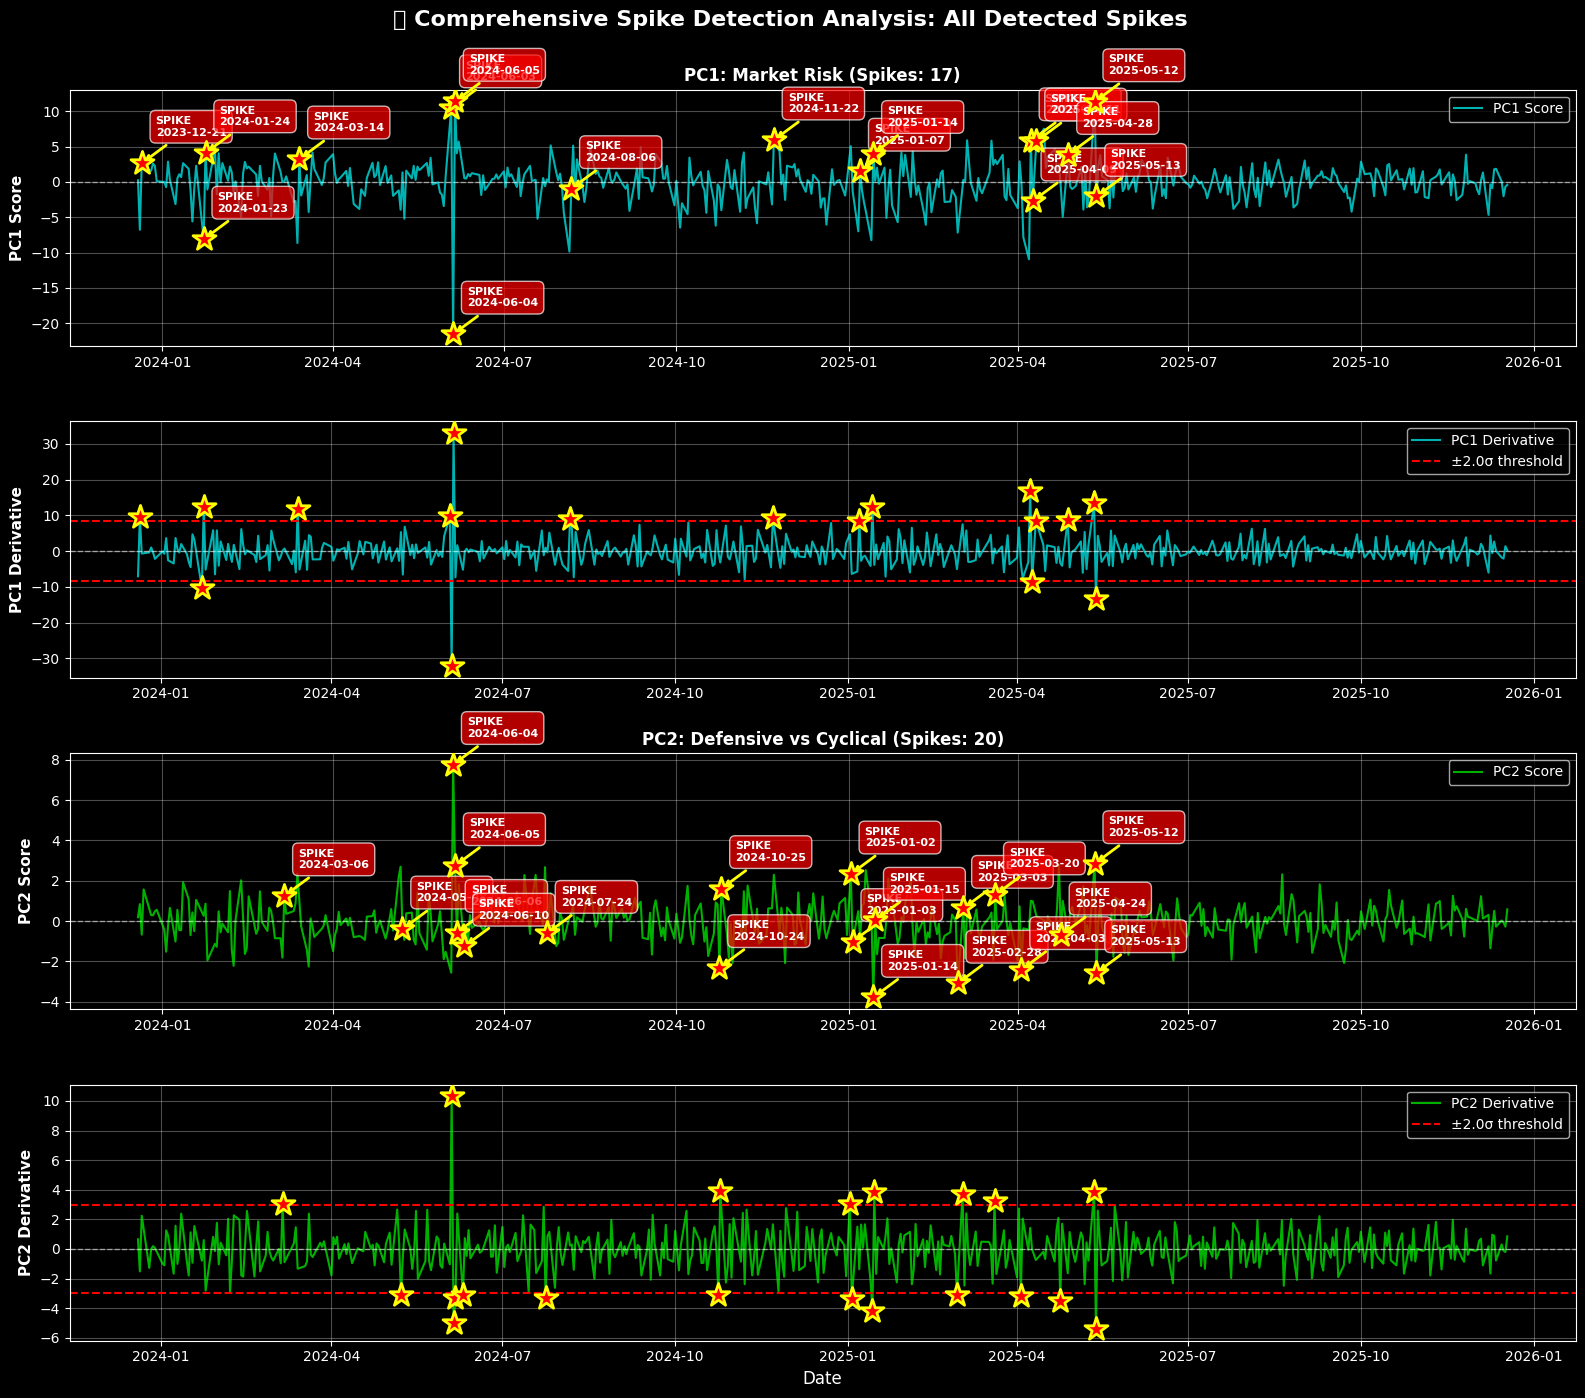


🔥 SPIKE DETECTION SUMMARY

📊 Total Spikes Detected: 61
   • PC1 spikes: 17
   • PC2 spikes: 20
   • PC3 spikes: 24

📅 Spike Timeline:
   • 2023-12-21: PC1 spike (derivative = 9.4271)
   • 2024-01-23: PC1 spike (derivative = -10.4261)
   • 2024-01-23: PC3 spike (derivative = -2.4955)
   • 2024-01-24: PC1 spike (derivative = 12.2434)
   • 2024-01-24: PC3 spike (derivative = 4.0685)
   • 2024-03-04: PC3 spike (derivative = 2.7227)
   • 2024-03-06: PC2 spike (derivative = 3.0590)
   • 2024-03-14: PC1 spike (derivative = 11.8963)
   • 2024-03-14: PC3 spike (derivative = 2.8318)
   • 2024-04-29: PC3 spike (derivative = -2.6673)
   ... and 51 more spikes


In [27]:
# Create comprehensive spike summary plot
fig, axes = plt.subplots(4, 1, figsize=(16, 14))
fig.suptitle('🔥 Comprehensive Spike Detection Analysis: All Detected Spikes', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: PC1 scores and spikes
ax = axes[0]
ax.plot(pc_scores.index, pc_scores['PC1'], linewidth=1.5, color='cyan', alpha=0.7, label='PC1 Score')
for spike_date, spike_val in spikes['PC1']:
    if spike_date in pc_scores.index:
        ax.scatter(spike_date, pc_scores.loc[spike_date, 'PC1'], 
                  s=300, color='red', marker='*', zorder=5, edgecolors='yellow', linewidth=2)
        ax.annotate(f'SPIKE\n{spike_date.strftime("%Y-%m-%d")}', 
                   xy=(spike_date, pc_scores.loc[spike_date, 'PC1']),
                   xytext=(10, 20), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='yellow', lw=2),
                   fontsize=8, color='white', fontweight='bold')
ax.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('PC1 Score', fontsize=11, fontweight='bold')
ax.set_title(f'PC1: Market Risk (Spikes: {len(spikes["PC1"])})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: PC1 derivative
ax = axes[1]
ax.plot(pc_derivatives.index, pc_derivatives['PC1'], linewidth=1.5, color='cyan', alpha=0.7, label='PC1 Derivative')
threshold = SPIKE_THRESHOLD * pc_derivatives['PC1'].std()
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5, label=f'±{SPIKE_THRESHOLD}σ threshold')
ax.axhline(y=-threshold, color='red', linestyle='--', linewidth=1.5)
for spike_date, spike_val in spikes['PC1']:
    ax.scatter(spike_date, spike_val, s=300, color='red', marker='*', 
              zorder=5, edgecolors='yellow', linewidth=2)
ax.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('PC1 Derivative', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: PC2 scores and spikes
ax = axes[2]
ax.plot(pc_scores.index, pc_scores['PC2'], linewidth=1.5, color='lime', alpha=0.7, label='PC2 Score')
for spike_date, spike_val in spikes['PC2']:
    if spike_date in pc_scores.index:
        ax.scatter(spike_date, pc_scores.loc[spike_date, 'PC2'], 
                  s=300, color='red', marker='*', zorder=5, edgecolors='yellow', linewidth=2)
        ax.annotate(f'SPIKE\n{spike_date.strftime("%Y-%m-%d")}', 
                   xy=(spike_date, pc_scores.loc[spike_date, 'PC2']),
                   xytext=(10, 20), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='yellow', lw=2),
                   fontsize=8, color='white', fontweight='bold')
ax.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('PC2 Score', fontsize=11, fontweight='bold')
ax.set_title(f'PC2: Defensive vs Cyclical (Spikes: {len(spikes["PC2"])})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: PC2 derivative
ax = axes[3]
ax.plot(pc_derivatives.index, pc_derivatives['PC2'], linewidth=1.5, color='lime', alpha=0.7, label='PC2 Derivative')
threshold = SPIKE_THRESHOLD * pc_derivatives['PC2'].std()
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5, label=f'±{SPIKE_THRESHOLD}σ threshold')
ax.axhline(y=-threshold, color='red', linestyle='--', linewidth=1.5)
for spike_date, spike_val in spikes['PC2']:
    ax.scatter(spike_date, spike_val, s=300, color='red', marker='*', 
              zorder=5, edgecolors='yellow', linewidth=2)
ax.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('PC2 Derivative', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of all spikes
print("\n" + "=" * 80)
print("🔥 SPIKE DETECTION SUMMARY")
print("=" * 80)

total_spikes = sum(len(spikes[pc]) for pc in ['PC1', 'PC2', 'PC3'])
print(f"\n📊 Total Spikes Detected: {total_spikes}")
print(f"   • PC1 spikes: {len(spikes['PC1'])}")
print(f"   • PC2 spikes: {len(spikes['PC2'])}")
print(f"   • PC3 spikes: {len(spikes['PC3'])}")

print(f"\n📅 Spike Timeline:")
all_spikes_combined = []
for pc in ['PC1', 'PC2', 'PC3']:
    for spike_date, spike_val in spikes[pc]:
        all_spikes_combined.append((spike_date, pc, spike_val))

all_spikes_combined.sort(key=lambda x: x[0])

for spike_date, pc, spike_val in all_spikes_combined[:10]:  # Show first 10
    print(f"   • {spike_date.strftime('%Y-%m-%d')}: {pc} spike (derivative = {spike_val:.4f})")

if len(all_spikes_combined) > 10:
    print(f"   ... and {len(all_spikes_combined) - 10} more spikes")

print("=" * 80)


## 🔄 Part 15: Rolling PCA - A Better Approach Than Derivatives

### Why Rolling PCA is Better Than Derivatives

**Key Differences:**

| Aspect | Derivatives | Rolling PCA |
|--------|------------|-------------|
| **What it shows** | Rate of change | Structural changes |
| **Time horizon** | Instantaneous (1 day) | Structural (weeks/months) |
| **Sensitivity** | Very sensitive to noise | More stable, filters noise |
| **Interpretation** | "How fast is PC changing?" | "How is market structure changing?" |
| **Use case** | Short-term spike detection | Regime detection, structural shifts |

**Why Rolling PCA is Superior:**

1. **Structural vs. Noise:**
   - **Derivatives**: Capture every small fluctuation (including noise)
   - **Rolling PCA**: Shows how the underlying factor structure evolves (filters noise)

2. **Regime Detection:**
   - **Derivatives**: Can't tell if market structure changed
   - **Rolling PCA**: Directly shows when factor importance shifts (regime change)

3. **Stability:**
   - **Derivatives**: Very volatile, many false signals
   - **Rolling PCA**: Smooth evolution, fewer false signals

4. **Actionable Insights:**
   - **Derivatives**: "PC changed fast" (not very actionable)
   - **Rolling PCA**: "Market moved from PC1-dominant to PC2-dominant" (actionable!)

### What is Rolling PCA?

**Simple Explanation (Layman Terms):**

Imagine you're watching the stock market over time. Instead of looking at daily changes (derivatives), you:

1. **Take a window** of the last 60 days
2. **Compute PCA** on that window (find the main factors)
3. **See which factor is most important** (PC1, PC2, or PC3)
4. **Move the window forward** by 1 day
5. **Repeat** and see how factor importance changes over time

**Analogy:**
- **Derivatives** = Speedometer (how fast you're going right now)
- **Rolling PCA** = GPS showing which road you're on (the structural path)

### Mathematical Foundation

**Rolling PCA Process:**

For each time point t, with window size W:

1. **Extract window**: Returns from t-W to t
2. **Compute correlation matrix**: C_window(t)
3. **Eigenvalue decomposition**: C_window(t) = P(t) Λ(t) P(t)^T
4. **Extract variance explained**: λ_i(t) / Σλ(t) × 100%
5. **Track over time**: See how variance explained evolves

**Key Metrics:**

- **PC1 Variance(t)**: How much market risk explains movement in window t
- **PC2 Variance(t)**: How much sector rotation explains movement in window t
- **PC3 Variance(t)**: How much global/domestic explains movement in window t

**Regime Detection:**

- **PC1-dominant period**: PC1 variance > PC2 and PC3 variance
- **PC2-dominant period**: PC2 variance > PC1 and PC3 variance
- **Regime shift**: When dominant PC changes

### What You'll Get as Output

**1. Rolling Variance Explained:**
- Time series showing how much each PC explains over time
- Shows when market structure changes
- Identifies regime shifts

**2. Regime Timeline:**
- Which PC was dominant at each time
- When regime shifts occurred
- Duration of each regime

**3. Structural Changes:**
- When market moved from "flow-driven" to "rotation-driven"
- When global factors became more important
- When defensive vs cyclical rotation intensified

**4. Trading Implications:**
- Which strategy works in current regime
- When to switch strategies
- Early warning of regime changes

### Interpretation Guide

**Scenario 1: PC1 Variance High and Stable**
- **Meaning**: Market is consistently flow-driven
- **Action**: Use index strategies, sector selection less important

**Scenario 2: PC2 Variance Rising**
- **Meaning**: Sector rotation becoming more important
- **Action**: Switch to sector pairs trading, avoid index strategies

**Scenario 3: PC1 → PC2 Transition**
- **Meaning**: Regime shift from flow-driven to rotation-driven
- **Action**: Change strategy immediately, old strategy won't work

**Scenario 4: All PCs Similar Variance**
- **Meaning**: Choppy market, no clear factor
- **Action**: Avoid factor strategies, focus on stock selection


In [ ]:
# ============================================================================
# ROLLING PCA ANALYSIS
# ============================================================================

print("=" * 80)
print("🔄 ROLLING PCA ANALYSIS: Tracking Market Structure Evolution")
print("=" * 80)

# Configuration
ROLLING_WINDOW = 60  # 60 trading days (~3 months)
STEP_SIZE = 1  # Move window by 1 day (can increase for faster computation)

print(f"\n📊 Configuration:")
print(f"   • Rolling window size: {ROLLING_WINDOW} trading days (~{ROLLING_WINDOW/20:.1f} months)")
print(f"   • Step size: {STEP_SIZE} day(s)")
print(f"   • Total time points: {len(returns_df) - ROLLING_WINDOW + 1}")

# Storage for rolling PCA results
rolling_results = {
    'dates': [],
    'pc1_variance': [],
    'pc2_variance': [],
    'pc3_variance': [],
    'pc1_eigenvalue': [],
    'pc2_eigenvalue': [],
    'pc3_eigenvalue': [],
    'dominant_pc': [],
    'cumulative_variance_top3': []
}

print(f"\n🔄 Computing rolling PCA...")
print("   This may take a moment...")

# Compute rolling PCA
for i in range(ROLLING_WINDOW, len(returns_df), STEP_SIZE):
    # Extract window
    window_returns = returns_df.iloc[i-ROLLING_WINDOW:i]
    
    # Compute correlation matrix for this window
    window_corr = window_returns.corr()
    
    # Eigenvalue decomposition
    window_eigenvalues, window_eigenvectors = np.linalg.eigh(window_corr)
    
    # Sort in descending order
    idx = window_eigenvalues.argsort()[::-1]
    window_eigenvalues = window_eigenvalues[idx]
    
    # Calculate variance explained
    total_variance = window_eigenvalues.sum()
    window_pve = (window_eigenvalues / total_variance) * 100
    
    # Store results
    rolling_results['dates'].append(returns_df.index[i-1])  # End date of window
    rolling_results['pc1_variance'].append(window_pve[0])
    rolling_results['pc2_variance'].append(window_pve[1])
    rolling_results['pc3_variance'].append(window_pve[2])
    rolling_results['pc1_eigenvalue'].append(window_eigenvalues[0])
    rolling_results['pc2_eigenvalue'].append(window_eigenvalues[1])
    rolling_results['pc3_eigenvalue'].append(window_eigenvalues[2])
    
    # Determine dominant PC
    if window_pve[0] > window_pve[1] and window_pve[0] > window_pve[2]:
        dominant_pc = 'PC1'
    elif window_pve[1] > window_pve[2]:
        dominant_pc = 'PC2'
    else:
        dominant_pc = 'PC3'
    rolling_results['dominant_pc'].append(dominant_pc)
    
    rolling_results['cumulative_variance_top3'].append(window_pve[:3].sum())

# Convert to DataFrame
rolling_pca_df = pd.DataFrame(rolling_results)
rolling_pca_df.set_index('dates', inplace=True)

print(f"✅ Rolling PCA complete!")
print(f"   • Computed {len(rolling_pca_df)} rolling windows")
print(f"   • Date range: {rolling_pca_df.index[0].date()} to {rolling_pca_df.index[-1].date()}")

# Summary statistics
print(f"\n📊 Summary Statistics:")
print(f"   • Average PC1 variance: {rolling_pca_df['pc1_variance'].mean():.2f}%")
print(f"   • Average PC2 variance: {rolling_pca_df['pc2_variance'].mean():.2f}%")
print(f"   • Average PC3 variance: {rolling_pca_df['pc3_variance'].mean():.2f}%")

# Regime statistics
pc1_dominant = (rolling_pca_df['dominant_pc'] == 'PC1').sum()
pc2_dominant = (rolling_pca_df['dominant_pc'] == 'PC2').sum()
pc3_dominant = (rolling_pca_df['dominant_pc'] == 'PC3').sum()
total = len(rolling_pca_df)

print(f"\n🔍 Regime Distribution:")
print(f"   • PC1-dominant: {pc1_dominant} periods ({100*pc1_dominant/total:.1f}%)")
print(f"   • PC2-dominant: {pc2_dominant} periods ({100*pc2_dominant/total:.1f}%)")
print(f"   • PC3-dominant: {pc3_dominant} periods ({100*pc3_dominant/total:.1f}%)")

print("=" * 80)


In [ ]:
# Plot 1: Rolling Variance Explained Over Time
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('🔄 Rolling PCA: Evolution of Factor Importance Over Time', 
             fontsize=16, fontweight='bold', y=0.995)

# Top plot: Variance Explained
ax1 = axes[0]
ax1.plot(rolling_pca_df.index, rolling_pca_df['pc1_variance'], 
         linewidth=2, color='cyan', alpha=0.8, label='PC1: Market Risk')
ax1.plot(rolling_pca_df.index, rolling_pca_df['pc2_variance'], 
         linewidth=2, color='lime', alpha=0.8, label='PC2: Defensive vs Cyclical')
ax1.plot(rolling_pca_df.index, rolling_pca_df['pc3_variance'], 
         linewidth=2, color='orange', alpha=0.8, label='PC3: Global vs Domestic')

# Fill areas to show dominance
ax1.fill_between(rolling_pca_df.index, 0, rolling_pca_df['pc1_variance'], 
                 where=(rolling_pca_df['dominant_pc'] == 'PC1'), 
                 alpha=0.2, color='cyan', label='PC1 Dominant Periods')
ax1.fill_between(rolling_pca_df.index, 0, rolling_pca_df['pc2_variance'], 
                 where=(rolling_pca_df['dominant_pc'] == 'PC2'), 
                 alpha=0.2, color='lime', label='PC2 Dominant Periods')
ax1.fill_between(rolling_pca_df.index, 0, rolling_pca_df['pc3_variance'], 
                 where=(rolling_pca_df['dominant_pc'] == 'PC3'), 
                 alpha=0.2, color='orange', label='PC3 Dominant Periods')

ax1.set_ylabel('Variance Explained (%)', fontsize=12, fontweight='bold')
ax1.set_title('Rolling Variance Explained: Which Factor Dominates?', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(rolling_pca_df[['pc1_variance', 'pc2_variance', 'pc3_variance']].max()) * 1.1)

# Bottom plot: Cumulative Variance (Top 3 PCs)
ax2 = axes[1]
ax2.plot(rolling_pca_df.index, rolling_pca_df['cumulative_variance_top3'], 
         linewidth=2, color='yellow', alpha=0.8, label='Cumulative (PC1+PC2+PC3)')
ax2.axhline(y=80, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='80% threshold')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='90% threshold')
ax2.fill_between(rolling_pca_df.index, rolling_pca_df['cumulative_variance_top3'], 
                 alpha=0.3, color='yellow')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Variance: How Much Do Top 3 Factors Explain?', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   📊 Top plot shows which factor (PC1, PC2, or PC3) is most important over time")
print("   📈 Colored areas highlight periods when each PC dominates")
print("   📉 Bottom plot shows how much the top 3 factors explain (higher = more structured market)")
print("   🔄 Changes in dominance = Regime shifts")


In [ ]:
# Plot 2: Regime Timeline and Transitions
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('🔄 Rolling PCA: Regime Detection and Transitions', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Individual PC variances with regime shading
ax1 = axes[0]
ax1.plot(rolling_pca_df.index, rolling_pca_df['pc1_variance'], 
         linewidth=2.5, color='cyan', alpha=0.9, label='PC1 Variance', zorder=3)
ax1.plot(rolling_pca_df.index, rolling_pca_df['pc2_variance'], 
         linewidth=2.5, color='lime', alpha=0.9, label='PC2 Variance', zorder=3)
ax1.plot(rolling_pca_df.index, rolling_pca_df['pc3_variance'], 
         linewidth=2.5, color='orange', alpha=0.9, label='PC3 Variance', zorder=3)

# Shade dominant periods
for i, (date, row) in enumerate(rolling_pca_df.iterrows()):
    if row['dominant_pc'] == 'PC1':
        color = 'cyan'
    elif row['dominant_pc'] == 'PC2':
        color = 'lime'
    else:
        color = 'orange'
    
    if i < len(rolling_pca_df) - 1:
        next_date = rolling_pca_df.index[i+1]
        ax1.axvspan(date, next_date, alpha=0.15, color=color, zorder=1)

ax1.set_ylabel('Variance Explained (%)', fontsize=12, fontweight='bold')
ax1.set_title('Rolling Variance Explained with Regime Shading', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Regime indicator (which PC is dominant)
ax2 = axes[1]
regime_numeric = rolling_pca_df['dominant_pc'].map({'PC1': 1, 'PC2': 2, 'PC3': 3})
ax2.plot(rolling_pca_df.index, regime_numeric, linewidth=2, color='white', alpha=0.8)
ax2.fill_between(rolling_pca_df.index, 0, regime_numeric, 
                 where=(regime_numeric == 1), alpha=0.5, color='cyan', label='PC1 Dominant')
ax2.fill_between(rolling_pca_df.index, 0, regime_numeric, 
                 where=(regime_numeric == 2), alpha=0.5, color='lime', label='PC2 Dominant')
ax2.fill_between(rolling_pca_df.index, 0, regime_numeric, 
                 where=(regime_numeric == 3), alpha=0.5, color='orange', label='PC3 Dominant')
ax2.set_ylabel('Dominant PC', fontsize=12, fontweight='bold')
ax2.set_title('Regime Timeline: Which Factor is Dominant?', fontsize=13, fontweight='bold')
ax2.set_yticks([1, 2, 3])
ax2.set_yticklabels(['PC1', 'PC2', 'PC3'])
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Detect regime transitions
ax3 = axes[2]
regime_changes = []
prev_regime = None
for date, row in rolling_pca_df.iterrows():
    current_regime = row['dominant_pc']
    if prev_regime is not None and current_regime != prev_regime:
        regime_changes.append((date, prev_regime, current_regime))
    prev_regime = current_regime

# Plot variance difference (PC1 - PC2) to show transitions
variance_diff = rolling_pca_df['pc1_variance'] - rolling_pca_df['pc2_variance']
ax3.plot(rolling_pca_df.index, variance_diff, linewidth=2, color='white', alpha=0.8, label='PC1 - PC2 Variance')
ax3.axhline(y=0, color='yellow', linestyle='--', linewidth=2, alpha=0.7, label='Equal Importance')
ax3.fill_between(rolling_pca_df.index, 0, variance_diff, 
                 where=(variance_diff > 0), alpha=0.3, color='cyan', label='PC1 > PC2')
ax3.fill_between(rolling_pca_df.index, 0, variance_diff, 
                 where=(variance_diff < 0), alpha=0.3, color='lime', label='PC2 > PC1')

# Mark regime transitions
for date, from_regime, to_regime in regime_changes:
    ax3.axvline(x=date, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax3.annotate(f'{from_regime}→{to_regime}', xy=(date, variance_diff.loc[date]),
                xytext=(5, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
                fontsize=8, color='white', fontweight='bold', rotation=90)

ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Variance Difference (%)', fontsize=12, fontweight='bold')
ax3.set_title(f'Regime Transitions Detected: {len(regime_changes)} shifts', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🔄 Regime Transitions Detected: {len(regime_changes)}")
if len(regime_changes) > 0:
    print(f"\n📅 Transition Timeline:")
    for i, (date, from_regime, to_regime) in enumerate(regime_changes[:10]):  # Show first 10
        print(f"   • {date.strftime('%Y-%m-%d')}: {from_regime} → {to_regime}")
    if len(regime_changes) > 10:
        print(f"   ... and {len(regime_changes) - 10} more transitions")


In [ ]:
# Plot 3: Eigenvalue Evolution (Alternative View)
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('🔄 Rolling PCA: Eigenvalue Evolution (Factor Strength Over Time)', 
             fontsize=16, fontweight='bold', y=0.995)

# Top plot: Eigenvalues
ax1 = axes[0]
ax1.plot(rolling_pca_df.index, rolling_pca_df['pc1_eigenvalue'], 
         linewidth=2, color='cyan', alpha=0.8, label='PC1 Eigenvalue')
ax1.plot(rolling_pca_df.index, rolling_pca_df['pc2_eigenvalue'], 
         linewidth=2, color='lime', alpha=0.8, label='PC2 Eigenvalue')
ax1.plot(rolling_pca_df.index, rolling_pca_df['pc3_eigenvalue'], 
         linewidth=2, color='orange', alpha=0.8, label='PC3 Eigenvalue')
ax1.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, 
            label='Kaiser Criterion (λ=1)')
ax1.set_ylabel('Eigenvalue (λ)', fontsize=12, fontweight='bold')
ax1.set_title('Eigenvalue Evolution: Factor Strength Over Time', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Bottom plot: Ratio of PC2/PC1 and PC3/PC1 (shows relative importance)
ax2 = axes[1]
ratio_pc2_pc1 = rolling_pca_df['pc2_variance'] / rolling_pca_df['pc1_variance']
ratio_pc3_pc1 = rolling_pca_df['pc3_variance'] / rolling_pca_df['pc1_variance']

ax2.plot(rolling_pca_df.index, ratio_pc2_pc1, 
         linewidth=2, color='lime', alpha=0.8, label='PC2/PC1 Ratio')
ax2.plot(rolling_pca_df.index, ratio_pc3_pc1, 
         linewidth=2, color='orange', alpha=0.8, label='PC3/PC1 Ratio')
ax2.axhline(y=1, color='yellow', linestyle='--', linewidth=2, alpha=0.7, 
            label='Equal Importance (Ratio = 1)')
ax2.fill_between(rolling_pca_df.index, 0, ratio_pc2_pc1, 
                 where=(ratio_pc2_pc1 > 1), alpha=0.2, color='lime', label='PC2 > PC1')
ax2.fill_between(rolling_pca_df.index, 0, ratio_pc3_pc1, 
                 where=(ratio_pc3_pc1 > 1), alpha=0.2, color='orange', label='PC3 > PC1')

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Variance Ratio', fontsize=12, fontweight='bold')
ax2.set_title('Relative Factor Importance: When Do PC2/PC3 Become More Important Than PC1?', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   📊 Top plot: Eigenvalues show absolute factor strength (higher = stronger factor)")
print("   📈 Bottom plot: Ratios show when PC2 or PC3 become more important than PC1")
print("   🔄 Ratio > 1 means that PC is more important than PC1 (regime shift!)")


In [ ]:
# Summary and Interpretation
print("\n" + "=" * 80)
print("📊 ROLLING PCA ANALYSIS SUMMARY")
print("=" * 80)

# Current regime
current_regime = rolling_pca_df.iloc[-1]
print(f"\n🔍 Current Market Regime (Last {ROLLING_WINDOW} days):")
print(f"   • Dominant PC: {current_regime['dominant_pc']}")
print(f"   • PC1 Variance: {current_regime['pc1_variance']:.2f}%")
print(f"   • PC2 Variance: {current_regime['pc2_variance']:.2f}%")
print(f"   • PC3 Variance: {current_regime['pc3_variance']:.2f}%")
print(f"   • Cumulative (Top 3): {current_regime['cumulative_variance_top3']:.2f}%")

# Regime interpretation
if current_regime['dominant_pc'] == 'PC1':
    print(f"\n💡 Interpretation:")
    print(f"   → Market is PC1-driven (risk appetite factor dominates)")
    print(f"   → Broad market moves are key, sector rotation less important")
    print(f"   → Trading Implication: Use index strategies, sector selection less critical")
elif current_regime['dominant_pc'] == 'PC2':
    print(f"\n💡 Interpretation:")
    print(f"   → Market is PC2-driven (sector rotation factor dominates)")
    print(f"   → Defensive vs Cyclical rotation is key, not broad market moves")
    print(f"   → Trading Implication: Use sector pairs trading, avoid index strategies")
else:
    print(f"\n💡 Interpretation:")
    print(f"   → Market is PC3-driven (global/domestic factor dominates)")
    print(f"   → Currency/global factors driving markets")
    print(f"   → Trading Implication: Watch USD-INR, global markets, export-oriented stocks")

# Regime stability
regime_stability = []
current_regime_type = rolling_pca_df.iloc[0]['dominant_pc']
regime_start = rolling_pca_df.index[0]
for date, row in rolling_pca_df.iterrows():
    if row['dominant_pc'] != current_regime_type:
        regime_stability.append((current_regime_type, regime_start, date, 
                                 (date - regime_start).days))
        current_regime_type = row['dominant_pc']
        regime_start = date
# Add last regime
regime_stability.append((current_regime_type, regime_start, rolling_pca_df.index[-1],
                         (rolling_pca_df.index[-1] - regime_start).days))

print(f"\n📅 Regime Duration Analysis:")
for regime_type, start, end, duration in regime_stability[:5]:  # Show first 5
    print(f"   • {regime_type}: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')} ({duration} days)")

# Variance statistics
print(f"\n📊 Variance Statistics:")
print(f"   • PC1 variance range: {rolling_pca_df['pc1_variance'].min():.2f}% - {rolling_pca_df['pc1_variance'].max():.2f}%")
print(f"   • PC2 variance range: {rolling_pca_df['pc2_variance'].min():.2f}% - {rolling_pca_df['pc2_variance'].max():.2f}%")
print(f"   • PC3 variance range: {rolling_pca_df['pc3_variance'].min():.2f}% - {rolling_pca_df['pc3_variance'].max():.2f}%")

# Volatility of variance (shows regime stability)
pc1_vol = rolling_pca_df['pc1_variance'].std()
pc2_vol = rolling_pca_df['pc2_variance'].std()
pc3_vol = rolling_pca_df['pc3_variance'].std()

print(f"\n📈 Regime Stability (Lower = More Stable):")
print(f"   • PC1 variance volatility: {pc1_vol:.2f}%")
print(f"   • PC2 variance volatility: {pc2_vol:.2f}%")
print(f"   • PC3 variance volatility: {pc3_vol:.2f}%")

if pc1_vol < pc2_vol and pc1_vol < pc3_vol:
    print(f"   → PC1 is most stable (market factor consistently important)")
elif pc2_vol < pc3_vol:
    print(f"   → PC2 is most stable (sector rotation consistently important)")
else:
    print(f"   → PC3 is most stable (global/domestic factor consistently important)")

print("=" * 80)


## 📝 Detailed Interpretation Guide for Rolling PCA Plots

### Plot 1: Rolling Variance Explained

**What You See:**
- Three lines showing PC1, PC2, PC3 variance over time
- Colored shaded areas showing when each PC dominates

**How to Interpret:**

1. **PC1 Line High and Stable:**
   - Market is consistently flow-driven
   - Broad market moves dominate
   - **Action**: Use index strategies

2. **PC2 Line Rising Above PC1:**
   - Sector rotation becoming important
   - Defensive vs Cyclical rotation active
   - **Action**: Switch to sector pairs trading

3. **PC3 Line Spiking:**
   - Global/currency factors driving markets
   - Export-oriented stocks moving
   - **Action**: Watch USD-INR, global markets

4. **All Lines Similar:**
   - No clear factor dominance
   - Choppy market
   - **Action**: Avoid factor strategies

### Plot 2: Regime Timeline

**What You See:**
- Colored bars showing which PC is dominant at each time
- Red vertical lines marking regime transitions

**How to Interpret:**

1. **Long Cyan Periods:**
   - Extended PC1-dominant regime
   - Stable market structure
   - **Action**: Stick with current strategy

2. **Frequent Color Changes:**
   - Unstable market structure
   - Regime shifts happening often
   - **Action**: Be cautious, market is choppy

3. **Red Lines (Transitions):**
   - Market structure changed
   - Old strategy may not work
   - **Action**: Reassess and adjust strategy

### Plot 3: Eigenvalue Evolution

**What You See:**
- Eigenvalues showing absolute factor strength
- Ratios showing relative importance

**How to Interpret:**

1. **High Eigenvalues:**
   - Strong factors (clear market structure)
   - **Action**: Factor strategies work well

2. **Low Eigenvalues:**
   - Weak factors (unstructured market)
   - **Action**: Avoid factor strategies

3. **Ratio > 1:**
   - PC2 or PC3 more important than PC1
   - Regime shift occurred
   - **Action**: Change strategy immediately

### Key Takeaways

**Rolling PCA tells you:**
1. **What regime you're in** (PC1, PC2, or PC3 dominant)
2. **When regime changes** (transitions)
3. **How stable the regime is** (variance volatility)
4. **Which strategy to use** (based on dominant PC)

**This is better than derivatives because:**
- Shows structural changes, not just noise
- Provides actionable regime information
- More stable and reliable
- Directly tells you which strategy works


## 📝 Technical Notes: Why Derivatives Help Detect Spikes

### Mathematical Foundation

**Derivative Definition:**
```
dPC/dt ≈ (PC(t) - PC(t-1)) / Δt
```

Where:
- **PC(t)** = PC score at time t
- **Δt** = Time step (1 day in our case)
- **dPC/dt** = Rate of change of PC score

**Why This Works:**

1. **Amplification of Changes:**
   - Small absolute change in PC → Large relative change in derivative
   - Example: PC changes from 0.1 to 0.3 → Derivative = 0.2 (200% change)
   - Makes spikes more visible

2. **Directional Information:**
   - **Positive derivative** = PC increasing (factor strengthening)
   - **Negative derivative** = PC decreasing (factor weakening)
   - **Large |derivative|** = Rapid change = Spike

3. **Threshold Detection:**
   - Use statistical threshold: |derivative| > kσ (k = 2 or 3)
   - Filters out normal fluctuations
   - Identifies unusual rapid movements

### Financial Interpretation

**PC1 Derivative Spike:**
- **Positive spike** = Sudden risk-on surge (all indices rallying together)
- **Negative spike** = Sudden risk-off crash (all indices falling together)
- **Interpretation**: Market-wide shock (FII flows, macro news, global events)

**PC2 Derivative Spike:**
- **Positive spike** = Sudden defensive rotation (FMCG/Pharma up, Metals down)
- **Negative spike** = Sudden cyclical rotation (Metals up, FMCG down)
- **Interpretation**: Sector rotation shock (institutional reallocation, earnings)

**PC3 Derivative Spike:**
- **Positive spike** = Sudden global/export factor strengthening
- **Negative spike** = Sudden domestic factor strengthening
- **Interpretation**: Currency/global shock (USD-INR moves, trade news)

### Advantages Over Direct PC Score Analysis

1. **Sensitivity**: Derivatives are more sensitive to rapid changes
2. **Early Detection**: Can detect spikes as they develop
3. **Noise Filtering**: Statistical threshold filters normal fluctuations
4. **Quantitative**: Provides exact magnitude of rate of change

### Limitations

1. **Noise Amplification**: Derivatives also amplify noise
   - Solution: Use appropriate threshold (2σ or 3σ)

2. **Lag**: Derivative is backward-looking (needs previous value)
   - Solution: Use for detection, not prediction

3. **False Positives**: Large derivatives may not always mean market shocks
   - Solution: Cross-validate with index movements

### Best Practices

1. **Use Multiple Thresholds**: Try 2σ, 2.5σ, 3σ to see sensitivity
2. **Cross-Validate**: Check if indices with high loadings actually moved
3. **Context Matters**: Consider market conditions when interpreting spikes
4. **Combine with Regime Detection**: Spikes during regime shifts are more significant

### Conclusion

**Derivatives provide a powerful tool for spike detection because:**
- They amplify rapid changes
- They provide quantitative measure of shock intensity
- They enable automated detection using statistical thresholds
- They complement direct PC score analysis

**For traders:**
- Monitor PC derivatives in real-time
- Set alerts for derivative spikes
- Cross-validate with actual index movements
- Use spike information for risk management and strategy adjustment
